In [1]:
# import datetime
import os
import pandas
import numpy as np
import matplotlib.pyplot as plt
from datlib.FRED import *
from datlib.plots import *


#FRED.py
#. . . 
def bil_to_mil(series):
    return series* 10**3
# . . .
#fedProject.py
# . . .
data_codes  = {# Assets
               "Balance Sheet: Total Assets ($ Mil)": "WALCL",
               "Balance Sheet Securities, Prem-Disc, Repos, and Loans ($ Mil)": "WSRLL",
               "Balance Sheet: Securities Held Outright ($ Mil)": "WSHOSHO",
               ### breakdown of securities holdings ###
               "Balance Sheet: U.S. Treasuries Held Outright ($ Mil)":"WSHOTSL",
               "Balance Sheet: Federal Agency Debt Securities ($ Mil)" : "WSHOFADSL",
               "Balance Sheet: Mortgage-Backed Securities ($ Mil)": "WSHOMCB",
               # other forms of lending
               "Balance Sheet: Repos ($ Mil)": "WORAL",
               "Balance Sheet: Central Bank Liquidity Swaps ($ Mil)" : "SWPT",
               "Balance Sheet: Direct Lending ($ Mil)" : "WLCFLL",
               # unamortized value of securities held (due to changes in interest rates)
               "Balance Sheet: Unamortized Security Premiums ($ Mil)": "WUPSHO",
               # Liabilities
               "Balance Sheet: Total Liabilities ($ Mil)" : "WLTLECL",
               "Balance Sheet: Federal Reserve Notes Outstanding ($ Mil)" : "WLFN",
               "Balance Sheet: Reverse Repos ($ Mil)": "WLRRAL",
               ### Major share of deposits 
               "Balance Sheet: Deposits from Dep. Institutions ($ Mil)":"WLODLL",
               "Balance Sheet: U.S. Treasury General Account ($ Mil)": "WDTGAL",
               "Balance Sheet: Other Deposits ($ Mil)": "WOTHLB",
               "Balance Sheet: All Deposits ($ Mil)": "WLDLCL",
               # Capital
               "Balance Sheet: Total Capital": "WCTCL",
               # Interest Rates
               "Unemployment Rate": "UNRATE",
               "Nominal GDP ($ Bil)":"GDP",
               "Real GDP ($ Bil)":"GDPC1",
               "GDP Deflator":"GDPDEF",
               "CPI":"CPIAUCSL",
               "Core PCE":"PCEPILFE",
               "Private Investment":"GPDI",
               "Base: Total ($ Mil)": "BOGMBASE",
               "Base: Currency in Circulation ($ Bil)": "WCURCIR",
               "1 Month Treasury Rate (%)": "DGS1MO",
               "3 Month Treasury Rate (%)": "DGS3MO",               
               "1 Year Treasury Rate (%)": "DGS1",
               "2 Year Treasury Rate (%)": "DGS2",
               "10 Year Treasury Rate (%)": "DGS10",
               "30 Year Treasury Rate (%)": "DGS30",               
               "Effective Federal Funds Rate (%)": "DFF",
               "Federal Funds Target Rate (Pre-crisis)":"DFEDTAR",
               "Federal Funds Upper Target":"DFEDTARU",
               "Federal Funds Lower Target":"DFEDTARL",
               "Interest on Reserves (%)": "IOER",
               "VIX": "VIXCLS",
                "5 Year Forward Rate": "T5YIFR"
               }
inflation_target = .02
unemployment_target = .04
# Select start and end dates
start = datetime.datetime(2000, 1, 1)
end = datetime.datetime.today()
annual_div = {"Q":4,
             "W":52,
             "M":12}
# freq refers to data frequency. Choose "D", "W", "M", "Q", "A"
# a number may also be place in front of a letter. "2D" indicates
#       alternating days
if "data_gathered" not in locals():
    freq = "M"
    year = annual_div[freq]
    data = gather_data(data_codes, start, 
          end = end, freq = freq)
    data.fillna(0, inplace=True)
    for key in data.keys():
        data["Log " + key]= np.log(data[key])
    # Create new variables
    data_gathered = True

ticker = "^GSPC"
data["Base: Currency in Circulation ($ Mil)"] = data["Base: Currency in Circulation ($ Bil)"].mul(1000)
data["Base: Currency not in Circulation ($ Mil)"] = data["Base: Total ($ Mil)"].sub(data["Base: Currency in Circulation ($ Mil)"])
data["Currency in Circulation Growth Rate (%)"] = data["Base: Currency in Circulation ($ Mil)"].pct_change(year) * 100
data["% Currency not in Circulation"] = data["Base: Currency not in Circulation ($ Mil)"].div(data["Base: Total ($ Mil)"]) * 100
data["% Currency in Circulation"] = data["Base: Currency in Circulation ($ Mil)"].div(data["Base: Total ($ Mil)"]) * 100
data["Base: Total Growth Rate (%)"] = data["Base: Total ($ Mil)"]
data["Change % Currency not in Circulation"] = data["% Currency not in Circulation"].diff(year)    
data["Currency not in Circulation Growth Rate (%)"] = data["Base: Currency not in Circulation ($ Mil)"].pct_change(year) * 100    
data["Inflation (CPI)"] = data["CPI"].pct_change(year) * 100
data["Inflation (PCE)"] = data["Core PCE"].pct_change(year) * 100

data["Effective Federal Funds Rate Diff (%)"] = data["Effective Federal Funds Rate (%)"].diff(year)
data["1 Year Treasury Rate (%; diff)"] = data["1 Year Treasury Rate (%)"].diff(year)
data["2 Year Treasury Rate (%; diff)"] = data["2 Year Treasury Rate (%)"].diff(year)
data["10 Year Treasury Rate (%; diff)"] = data["10 Year Treasury Rate (%)"].diff(year)
data["30 Year Treasury Rate (%; diff)"] = data["30 Year Treasury Rate (%)"].diff(year)
data["Unemployment Rate Diff"] = data["Unemployment Rate"].diff(year)
data["Nominal GDP ($ Mil)"] = data["Nominal GDP ($ Bil)"].mul(1000)
data["Nominal GDP Growth Rate (%)"] = data["Nominal GDP ($ Bil)"].pct_change(year) * 100
data["Real GDP ($ Mil)"] = data["Real GDP ($ Bil)"].mul(1000)
data["Real GDP Growth Rate (%)"] = data["Real GDP ($ Bil)"].pct_change(year) * 100
data["Inflation (GDPDEF)"] = data["GDP Deflator"].pct_change(year) * 100
data["Real Currency in Circulation Growth Rate (%)"] = data["Currency in Circulation Growth Rate (%)"].sub(data["Inflation (GDPDEF)"])
data["Currency in Circulation Velocity"] = data["Nominal GDP ($ Mil)"].div(data["Base: Currency in Circulation ($ Mil)"])
data["Currency in Circulation % Change Velocity"] = data["Currency in Circulation Velocity"].pct_change(year)

data["Inflation Loss"]= data["Inflation (CPI)"].sub(inflation_target)
data["Unemployment Loss"]= data["Unemployment Rate"].sub(unemployment_target)
data["Inflation Loss Sq"]= data["Inflation (CPI)"].sub(inflation_target).pow(2)
data["Inflation Loss Sq"][data["Inflation Loss"] < 0] = data["Inflation Loss Sq"].mul(-1)

data["Unemployment Loss Sq"]= data["Unemployment Rate"].sub(unemployment_target).pow(2)
data["Unemployment Loss Sq"][data["Unemployment Loss"] < 0] = data["Unemployment Loss Sq"].mul(-1)



data["Inflation Loss Diff"]= data["Inflation Loss"].diff(year)
data["Unemployment Loss Diff"]= data["Unemployment Loss"].diff(year)
data["Inflation Loss Sq Diff"]= data["Inflation Loss Sq"].diff(year)
data["Unemployment Loss Sq Diff"]= data["Unemployment Loss Sq"].diff(year)



data["Linear Loss"] = data["Inflation Loss"].sub(data["Unemployment Loss"])
data["Loss Function"] = data["Inflation Loss Sq"].sub(data["Unemployment Loss Sq"])
data["Linear Loss Diff"] = data["Linear Loss"].diff(year)
data["Loss Function Diff"] = data["Loss Function"].diff(year)

data["Real 1 Year Treasury Rate"] = data["1 Year Treasury Rate (%)"].sub(data["Inflation (CPI)"])
data["Real 3 Month Treasury Rate"] = data["3 Month Treasury Rate (%)"].sub(data["Inflation (CPI)"])
data["Real 1 Month Treasury Rate"] = data["1 Month Treasury Rate (%)"].sub(data["Inflation (CPI)"])
data["Real Effective Federal Funds Rate"] = data['Effective Federal Funds Rate (%)'].sub(data["Inflation (CPI)"])

data["30 Year Minus 1 Year (%)"] = data["30 Year Treasury Rate (%)"].sub(data["1 Year Treasury Rate (%)"])
data["30 Year Minus 3 Month (%)"] = data["30 Year Treasury Rate (%)"].sub(data["3 Month Treasury Rate (%)"])
data["30 Year Minus 1 Month (%)"] = data["30 Year Treasury Rate (%)"].sub(data["1 Month Treasury Rate (%)"])
data["30 Year Minus Effective Federal Funds Rate"] = data["30 Year Treasury Rate (%)"].sub(data['Effective Federal Funds Rate (%)'])
data["10 Year Minus 2 Year (%)"] = data["10 Year Treasury Rate (%)"].sub(data["2 Year Treasury Rate (%)"])
data["10 Year Minus 1 Year (%)"] = data["10 Year Treasury Rate (%)"].sub(data["1 Year Treasury Rate (%)"])
data["10 Year Minus 3 Month (%)"] = data["10 Year Treasury Rate (%)"].sub(data["3 Month Treasury Rate (%)"])
data["10 Year Minus 1 Month (%)"] = data["10 Year Treasury Rate (%)"].sub(data["1 Month Treasury Rate (%)"])
data["10 Year Minus Effective Federal Funds Rate"] = data["10 Year Treasury Rate (%)"].sub(data['Effective Federal Funds Rate (%)'])

keys = list(data.keys())
keys = ["Date"] + keys
data["Date"] = data.index.astype(str)



C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [2]:
import yfinance as yfin
yfin.pdr_override()
data["S&P"]= web.get_data_yahoo(ticker, start = start, end = end).resample(freq).mean()["Close"].iloc[:-2]
data["S&P Growth Rate (%)"] = data["S&P"].pct_change(year)
data["S&P Growth Rate Change Diff (%)"] = data["S&P Growth Rate (%)"].diff(year)
data["Real S&P Growth Rate (%)"] = data["S&P Growth Rate (%)"].sub(data["Inflation (CPI)"])
data["VIX Diff"] = data["VIX"].diff(year)
data

[*********************100%***********************]  1 of 1 completed


,Balance Sheet: Total Assets ($ Mil),"Balance Sheet Securities, Prem-Disc, Repos, and Loans ($ Mil)",Balance Sheet: Securities Held Outright ($ Mil),Balance Sheet: U.S. Treasuries Held Outright ($ Mil),Balance Sheet: Federal Agency Debt Securities ($ Mil),Balance Sheet: Mortgage-Backed Securities ($ Mil),Balance Sheet: Repos ($ Mil),Balance Sheet: Central Bank Liquidity Swaps ($ Mil),Balance Sheet: Direct Lending ($ Mil),Balance Sheet: Unamortized Security Premiums ($ Mil),...,10 Year Minus 1 Year (%),10 Year Minus 3 Month (%),10 Year Minus 1 Month (%),10 Year Minus Effective Federal Funds Rate,Date,S&P,S&P Growth Rate (%),S&P Growth Rate Change Diff (%),Real S&P Growth Rate (%),VIX Diff
DATE,,,,,,,,,,,,,,,,,,,,,
2002-12-31,725800.50,672844.50,629409.50,629399.50,10.0,0.00,33625.00,0.00,52.00,10811.00,...,2.582381,2.821429,2.834762,2.793994,2002-12-31,899.178574,NaN,NaN,NaN,NaN
2003-01-31,724718.40,671196.20,629416.00,629406.00,10.0,0.00,32100.00,0.00,19.40,10688.00,...,2.684286,2.859524,2.878095,2.813410,2003-01-31,895.836190,NaN,NaN,NaN,NaN
2003-02-28,721326.00,668666.25,631911.75,631901.75,10.0,0.00,27185.50,0.00,10.50,10571.25,...,2.606316,2.717368,2.707368,2.640489,2003-02-28,837.618951,NaN,NaN,NaN,NaN
2003-03-31,723651.25,672446.00,639168.25,639158.25,10.0,0.00,23625.00,0.00,11.00,10619.25,...,2.567143,2.656190,2.630952,2.554240,2003-03-31,846.621425,NaN,NaN,NaN,NaN
2003-04-30,736926.40,685518.60,645508.60,645498.60,10.0,0.00,30350.20,0.00,31.80,10574.40,...,2.691429,2.806190,2.800476,2.700571,2003-04-30,890.025713,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-30,7775974.00,7614925.00,7207246.25,4986900.00,2347.0,2217999.25,0.00,759.75,67584.00,350857.25,...,1.574091,1.614091,1.618636,1.566000,2021-04-30,4141.176200,0.499353,0.548194,-3.653782,-24.037619
2021-05-31,7866893.25,7709974.25,7291913.75,5063447.75,2347.0,2226119.00,11.75,642.50,81423.00,349622.50,...,1.570500,1.603000,1.613500,1.562935,2021-05-31,4167.849536,0.427537,0.404802,-4.498970,-11.136500
2021-06-30,8026555.20,7874851.20,7450341.40,5149903.00,2347.0,2298091.20,0.00,516.00,87694.60,350797.60,...,1.452273,1.483182,1.491818,1.441091,2021-06-30,4238.489546,0.365202,0.290987,-4.959306,-14.162727


In [3]:
#fedProject
# . . . 
data["Balance Sheet: Direct Lending and Central Bank Liquidity Swaps"] =\
    data["Balance Sheet: Central Bank Liquidity Swaps ($ Mil)"].add(
    data["Balance Sheet: Direct Lending ($ Mil)"])
data["Balance Sheet: Other Securities"] = data["Balance Sheet: Securities Held Outright ($ Mil)"].sub(
    data["Balance Sheet: U.S. Treasuries Held Outright ($ Mil)"]).sub(
    data["Balance Sheet: Mortgage-Backed Securities ($ Mil)"])
data["Balance Sheet: Other Assets"] = data["Balance Sheet: Total Assets ($ Mil)"].sub(
    data["Balance Sheet: Securities Held Outright ($ Mil)"]).sub(
    data["Balance Sheet: Direct Lending and Central Bank Liquidity Swaps"]).sub(
    data["Balance Sheet: Repos ($ Mil)"]).sub(
    data["Balance Sheet: Unamortized Security Premiums ($ Mil)"])
data["Balance Sheet: Other Deposits ($ Mil)"] = data["Balance Sheet: All Deposits ($ Mil)"].sub(
    data["Balance Sheet: U.S. Treasury General Account ($ Mil)"]).sub(
    data["Balance Sheet: Deposits from Dep. Institutions ($ Mil)"])
data["Balance Sheet: Other Liabilities"]= data["Balance Sheet: Total Liabilities ($ Mil)"].sub(
    data["Balance Sheet: Federal Reserve Notes Outstanding ($ Mil)"]).sub(
    data["Balance Sheet: U.S. Treasury General Account ($ Mil)"]).sub(
    data["Balance Sheet: Deposits from Dep. Institutions ($ Mil)"]).sub(
    data["Balance Sheet: Other Deposits ($ Mil)"]).sub(
    data["Balance Sheet: Reverse Repos ($ Mil)"])


<ipython-input-4-ab5c1d4011df>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(round(y,2))+ "%" for y in y_vals])


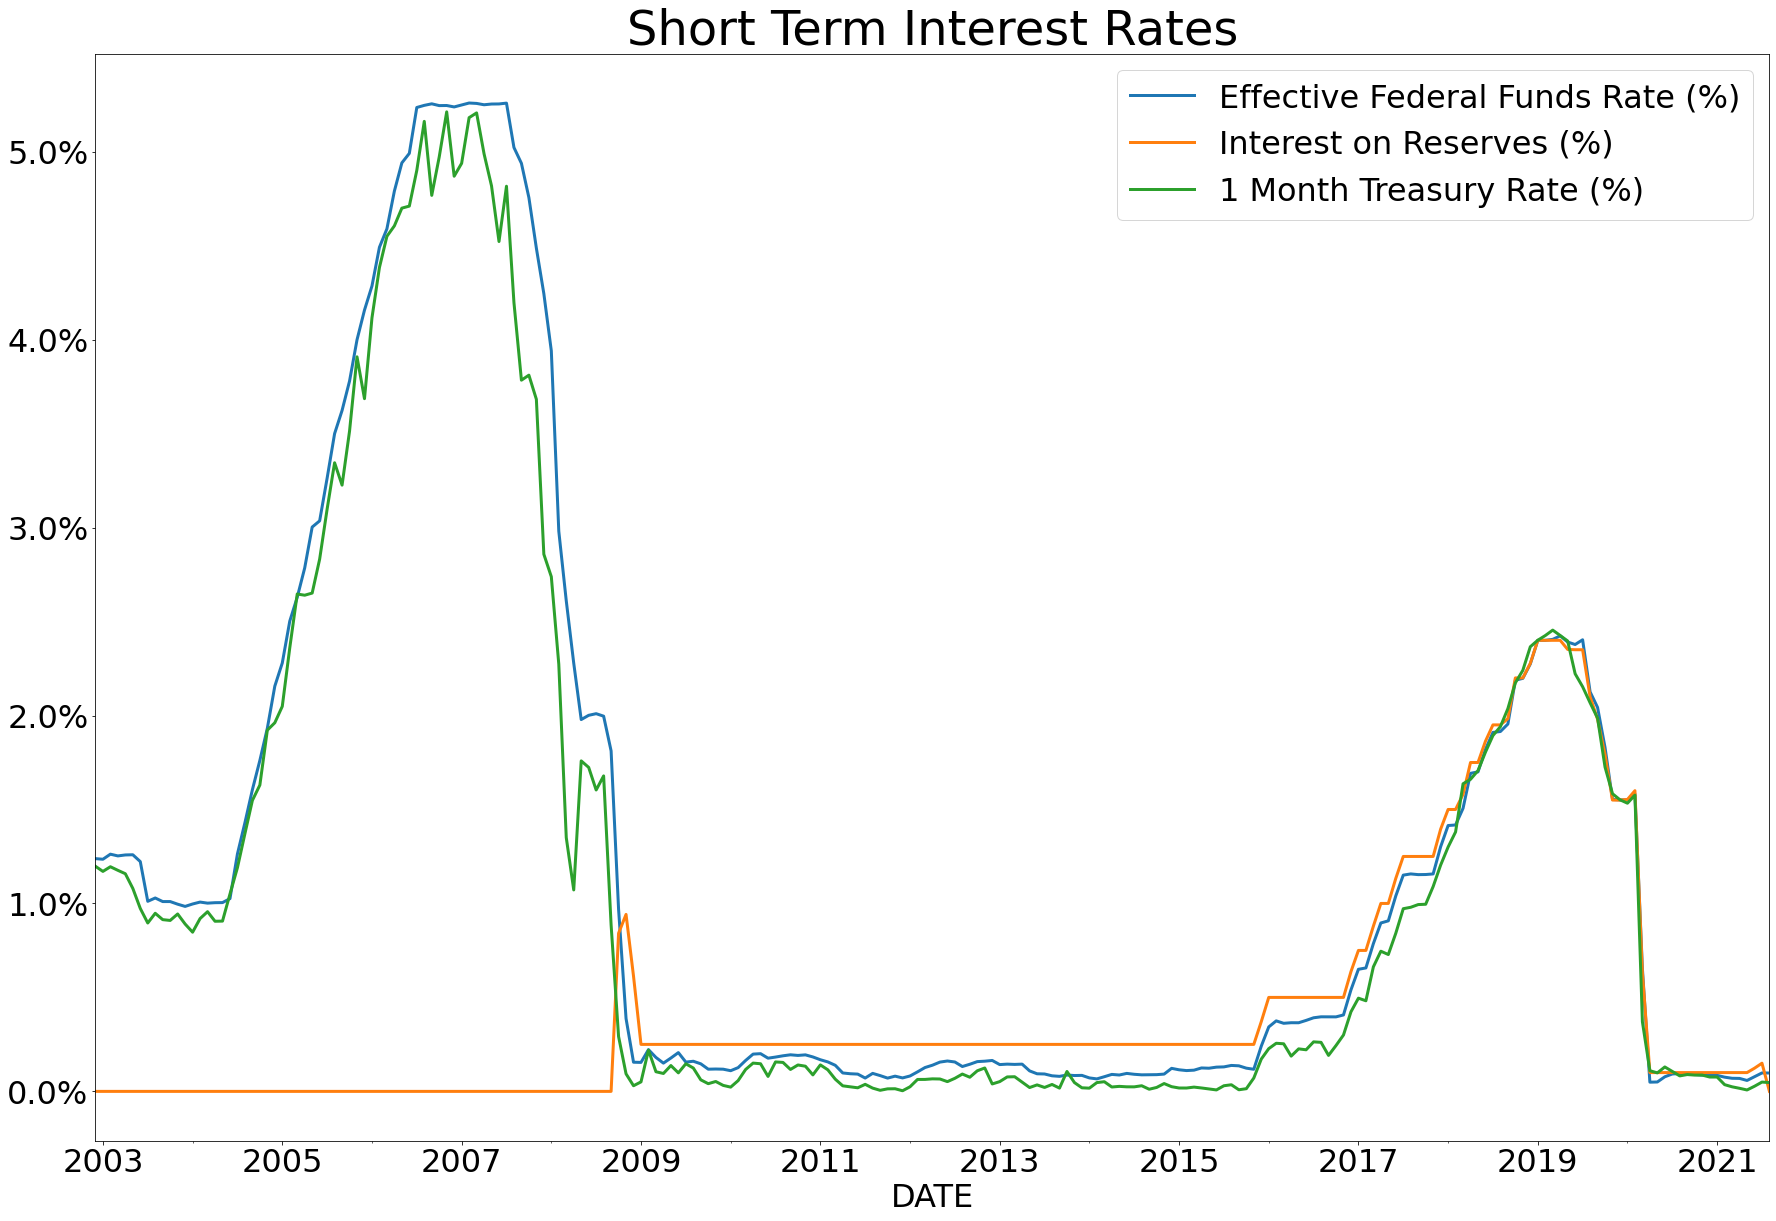

In [4]:
plt.rcParams.update({"font.size":32})
interest_vars = ["Effective Federal Funds Rate (%)",
                   "Interest on Reserves (%)",
                   "1 Month Treasury Rate (%)"]
fig, ax = plt.subplots(figsize = (30,20))
data[interest_vars].plot.line(legend=True, linewidth = 3, ax = ax)
y_vals = ax.get_yticks()
ax.set_yticklabels([str(round(y,2))+ "%" for y in y_vals])  
ax.set_title("Short Term Interest Rates", fontsize = 48)
data[["Date"] + interest_vars].to_json("shortTermRates.json", orient="records")

In [5]:
data = data.rename(columns = {
    key: key.replace("Balance Sheet: ", "").replace(" ($ Mil)", "").replace("Base: ","") for key in data.keys()})
keys = list(data.keys())
interest_rates = ["Effective Federal Funds Rate (%)",
                   "Interest on Reserves (%)",
                   "1 Month Treasury Rate (%)"]
plot_data = data.copy()
for key, val in data.items():
    if key not in interest_rates:
        try:
            plot_data[key] = val.div(10**6)
        except:
            continue

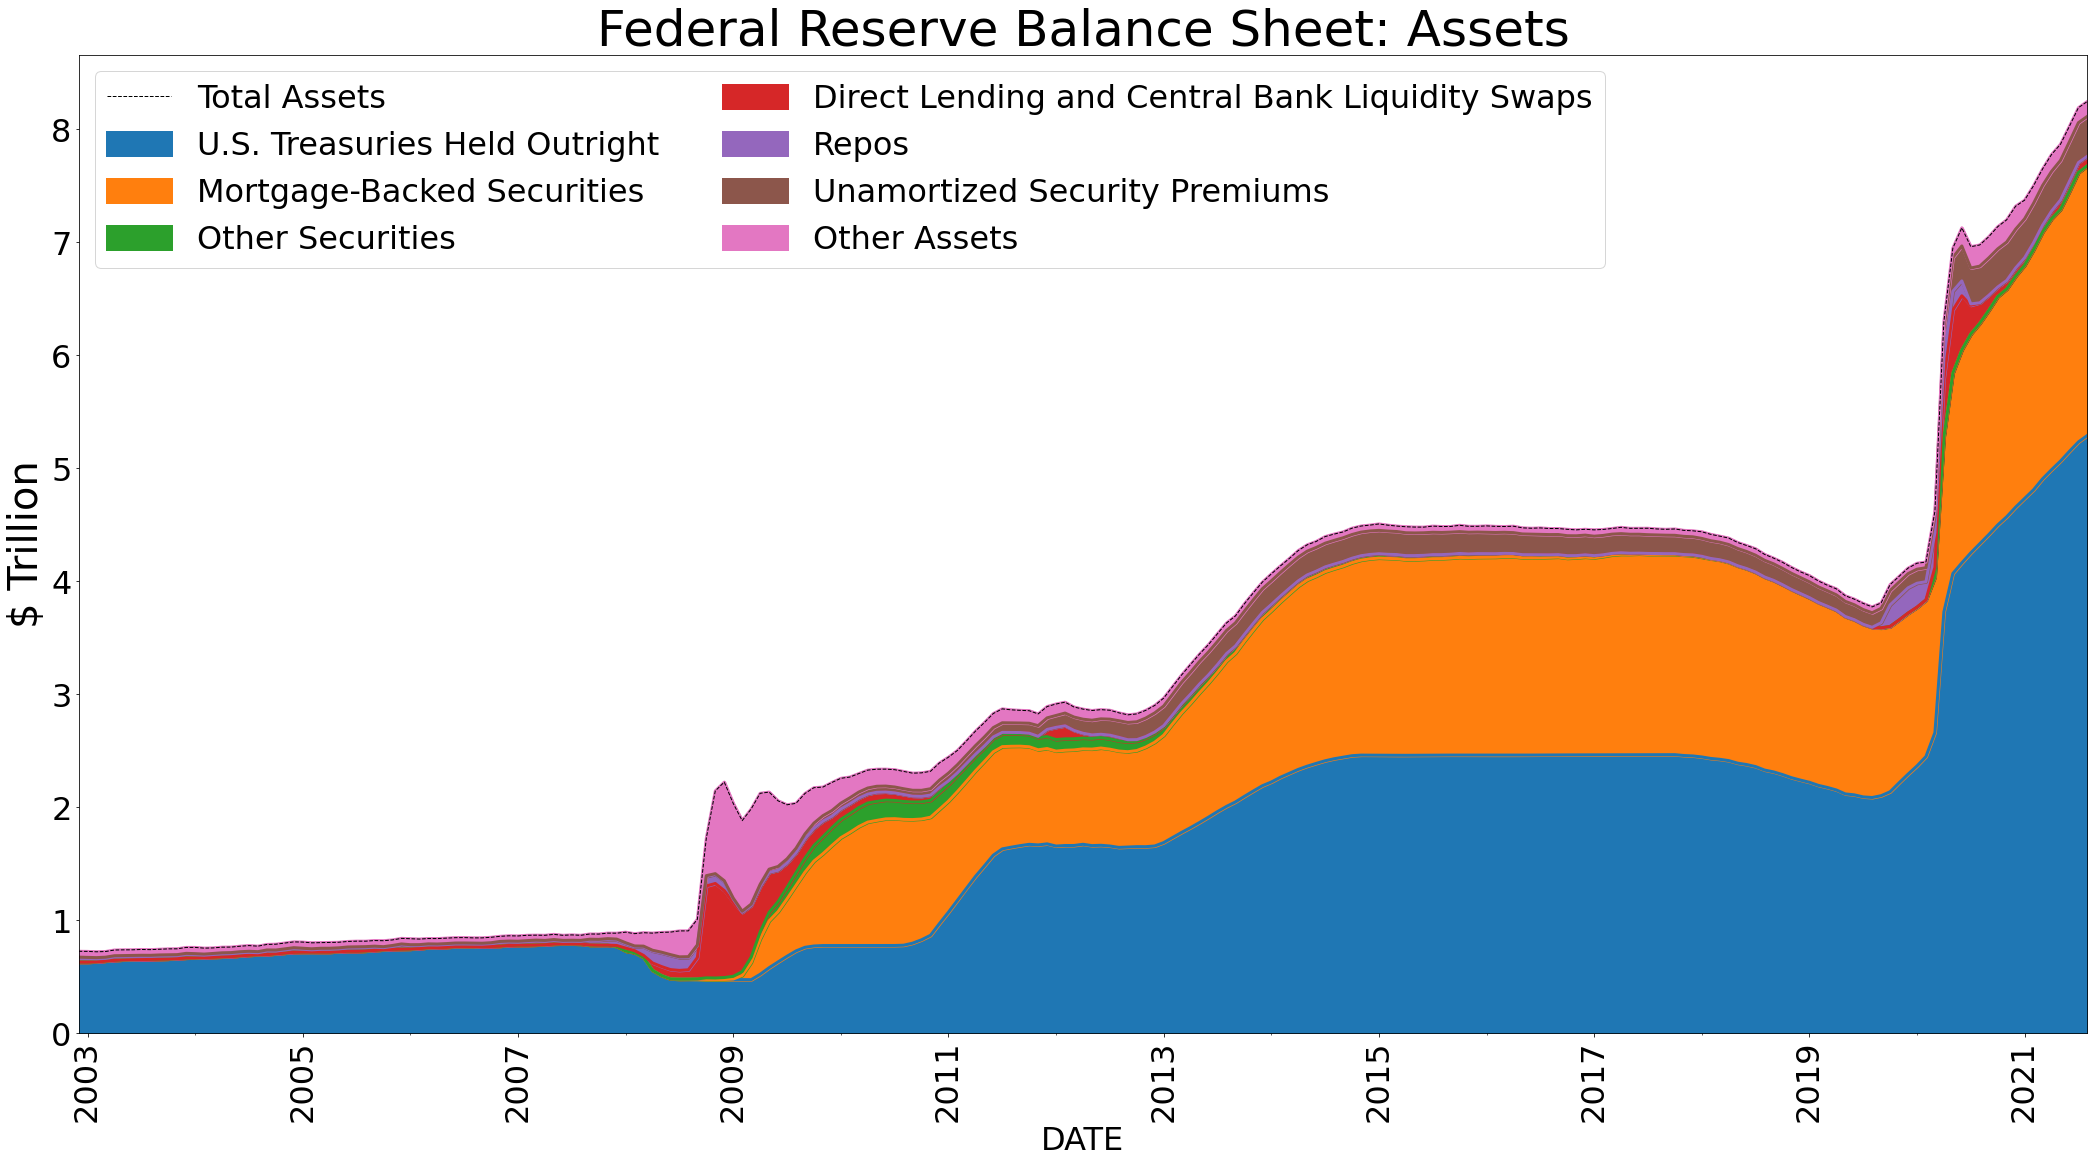

In [6]:
account_vars = ["U.S. Treasuries Held Outright",
               "Mortgage-Backed Securities",
               "Other Securities",
               "Direct Lending and Central Bank Liquidity Swaps",
               "Repos",
               "Unamortized Security Premiums",
               "Other Assets"]
figsize= (36,18)
fig, ax = plt.subplots(figsize = figsize)
plot_data[account_vars].plot.area(stacked = True, linewidth = 3,
                            ax = ax)
# change y vals from mil to tril
total_var = "Total Assets"
plot_data[total_var].plot.line(linewidth = 1, 
                             ax = ax, c = "k",
                             label = total_var, ls = "--")
plt.xticks(rotation = 90)
ax.legend(loc=2, ncol = 2)
ax.set_ylabel("$ Trillion", fontsize = 40)
ax.set_title("Federal Reserve Balance Sheet: Assets", fontsize = 50)
plot_data[[total_var] + account_vars].to_csv("FederalReserveAssets.csv")
plot_data[["Date"] + account_vars].to_json("fedAssets.json", orient = "records")

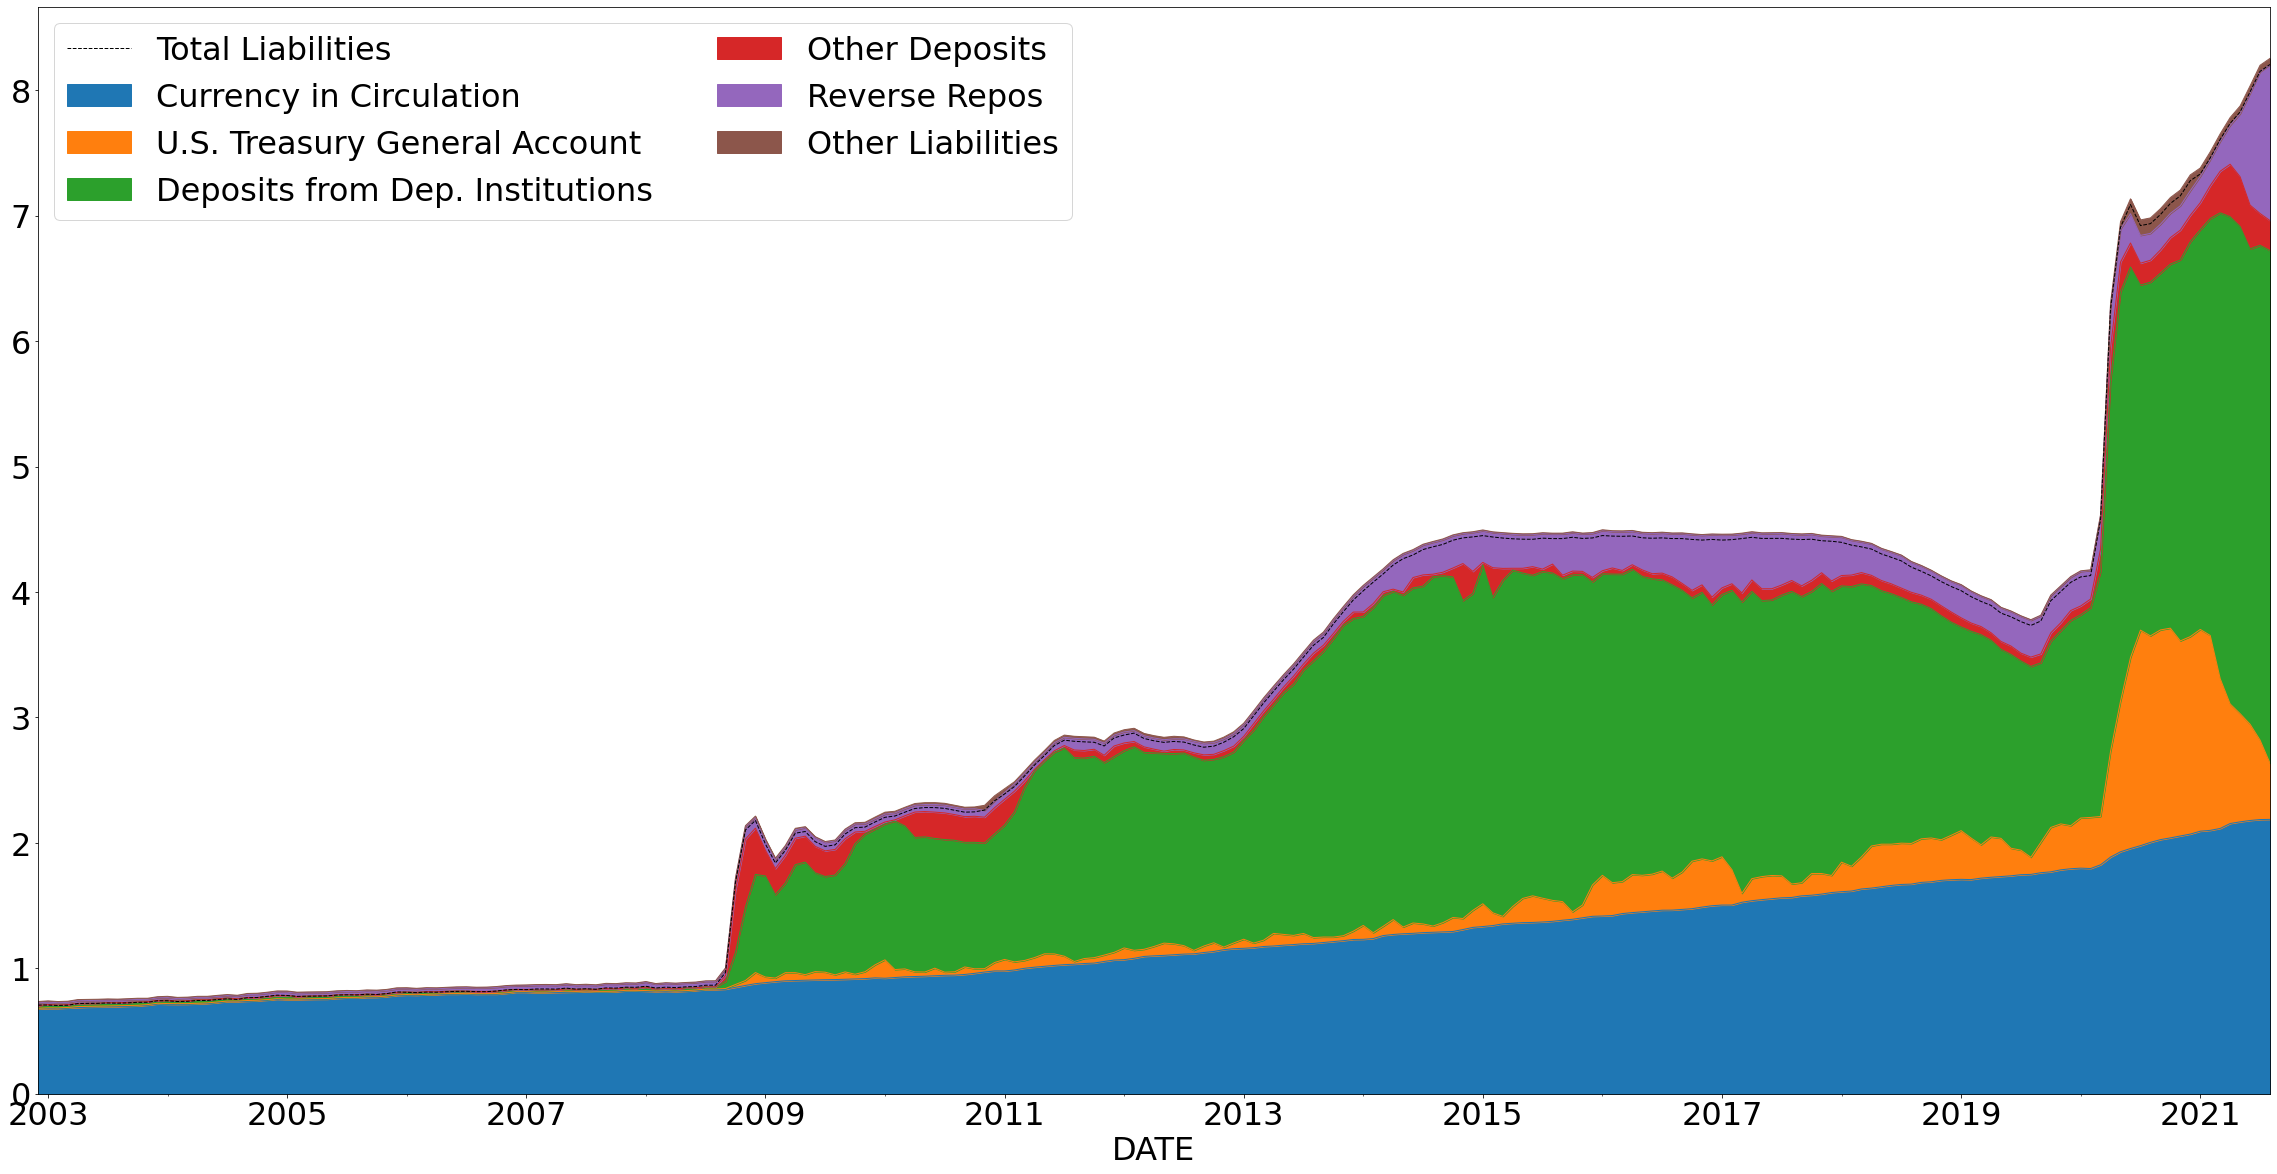

In [7]:
account_vars = ["Currency in Circulation",
                "U.S. Treasury General Account",
                "Deposits from Dep. Institutions",
                "Other Deposits",
                "Reverse Repos",
                "Other Liabilities"]
total_var = "Total Liabilities"

plot_stacked_lines(
    plot_data,
    account_vars, linewidth = 1,
    total_var = "Total Liabilities")


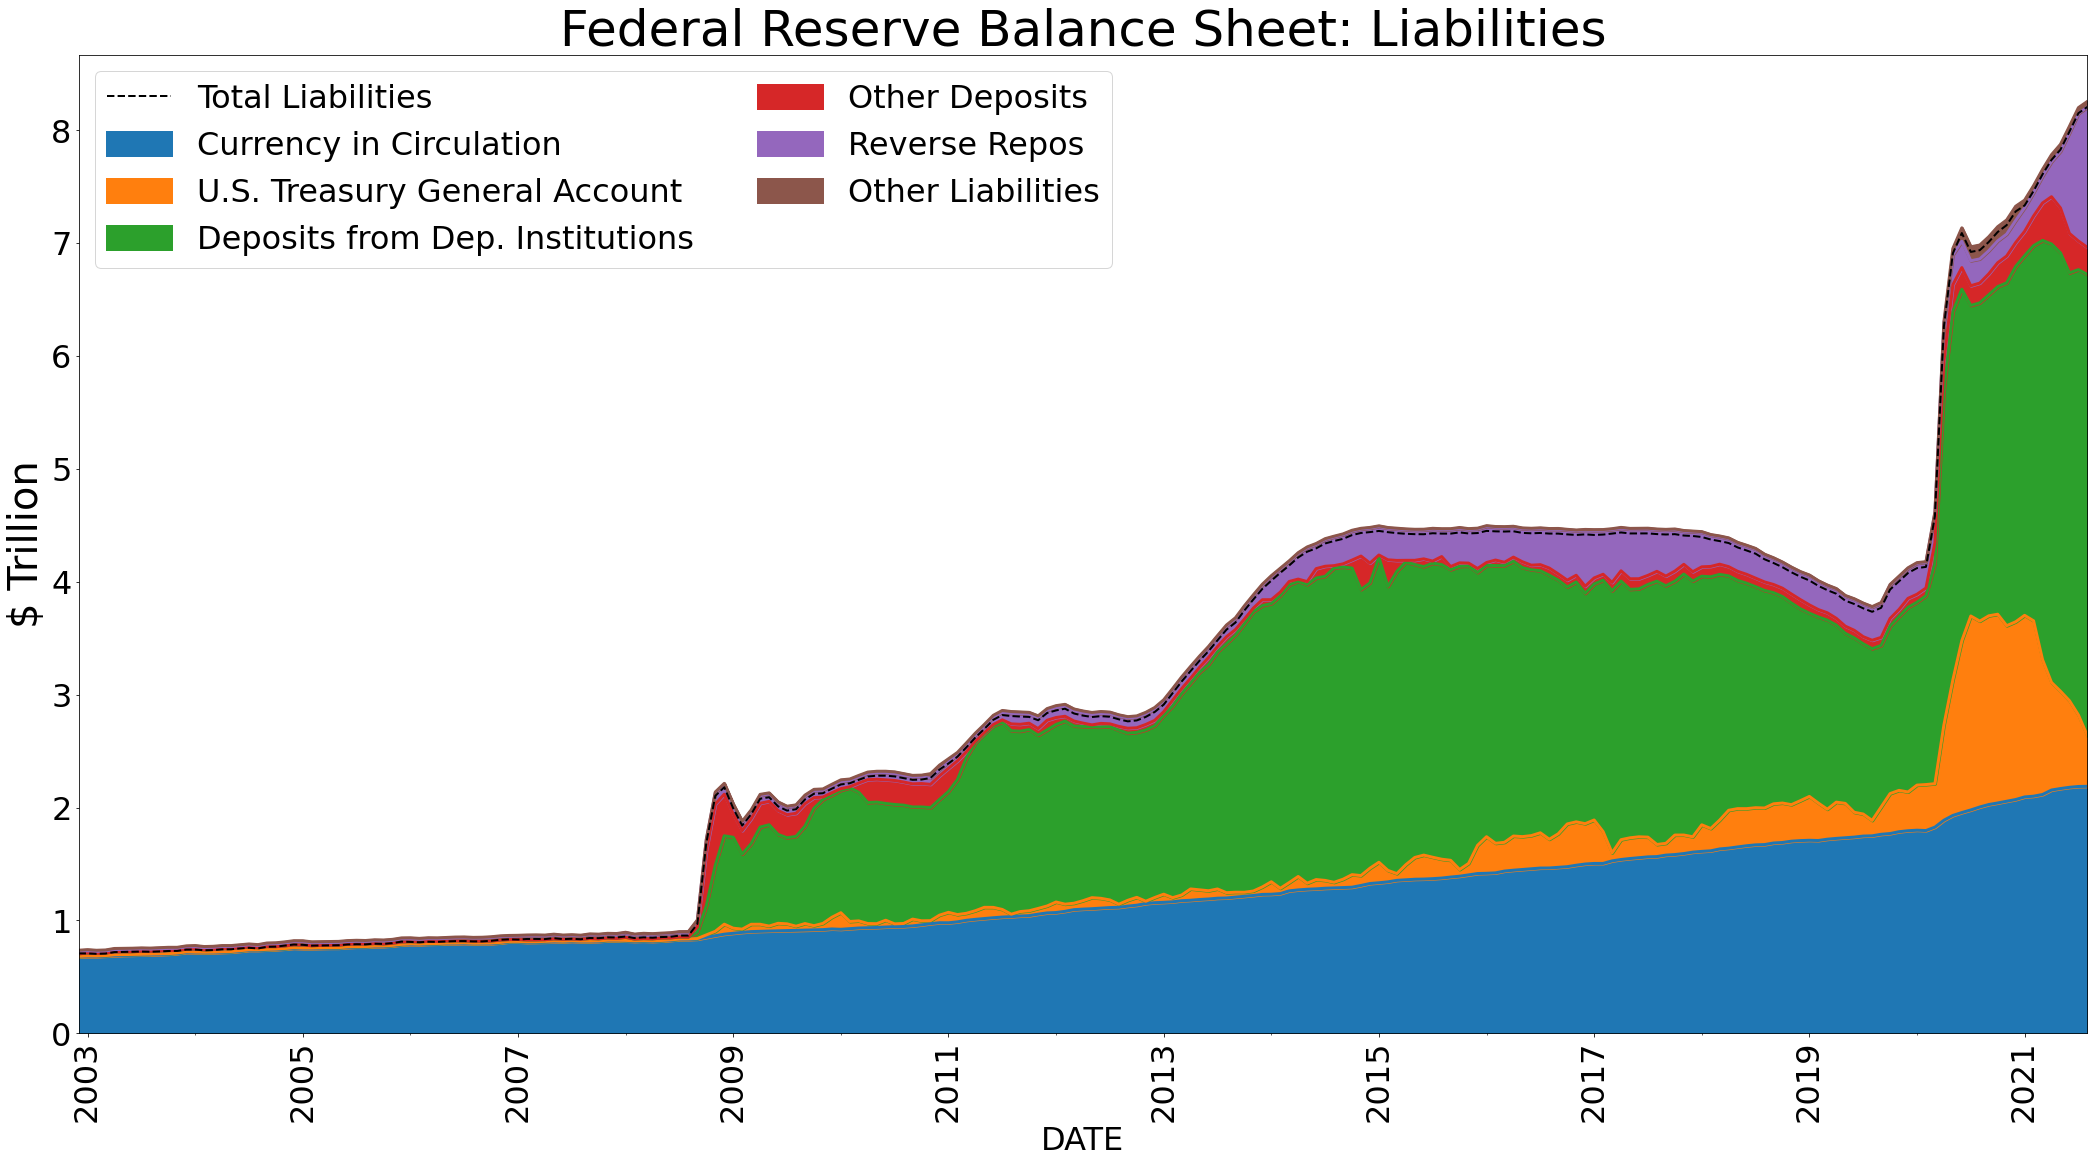

In [8]:
figsize= (36,18)
fig, ax = plt.subplots(figsize = figsize)
plot_data[account_vars].plot.area(stacked = True, linewidth = 3,
                            ax = ax)
# change y vals from mil to tril
total_var = "Total Liabilities"
plot_data[total_var].plot.line(linewidth = 2, 
                             ax = ax, c = "k",
                             label = total_var, ls = "--")
plt.xticks(rotation = 90)
ax.legend(loc=2, ncol = 2)
ax.set_ylabel("$ Trillion", fontsize = 40)
ax.set_title("Federal Reserve Balance Sheet: Liabilities", fontsize = 50)
plot_data[[total_var] + account_vars].to_csv("FederalReserveLiabilities.csv")

<ipython-input-9-bd89c59b9c46>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(int(val * 100)) + "% " for val in ax.get_yticks()], fontsize = 45)


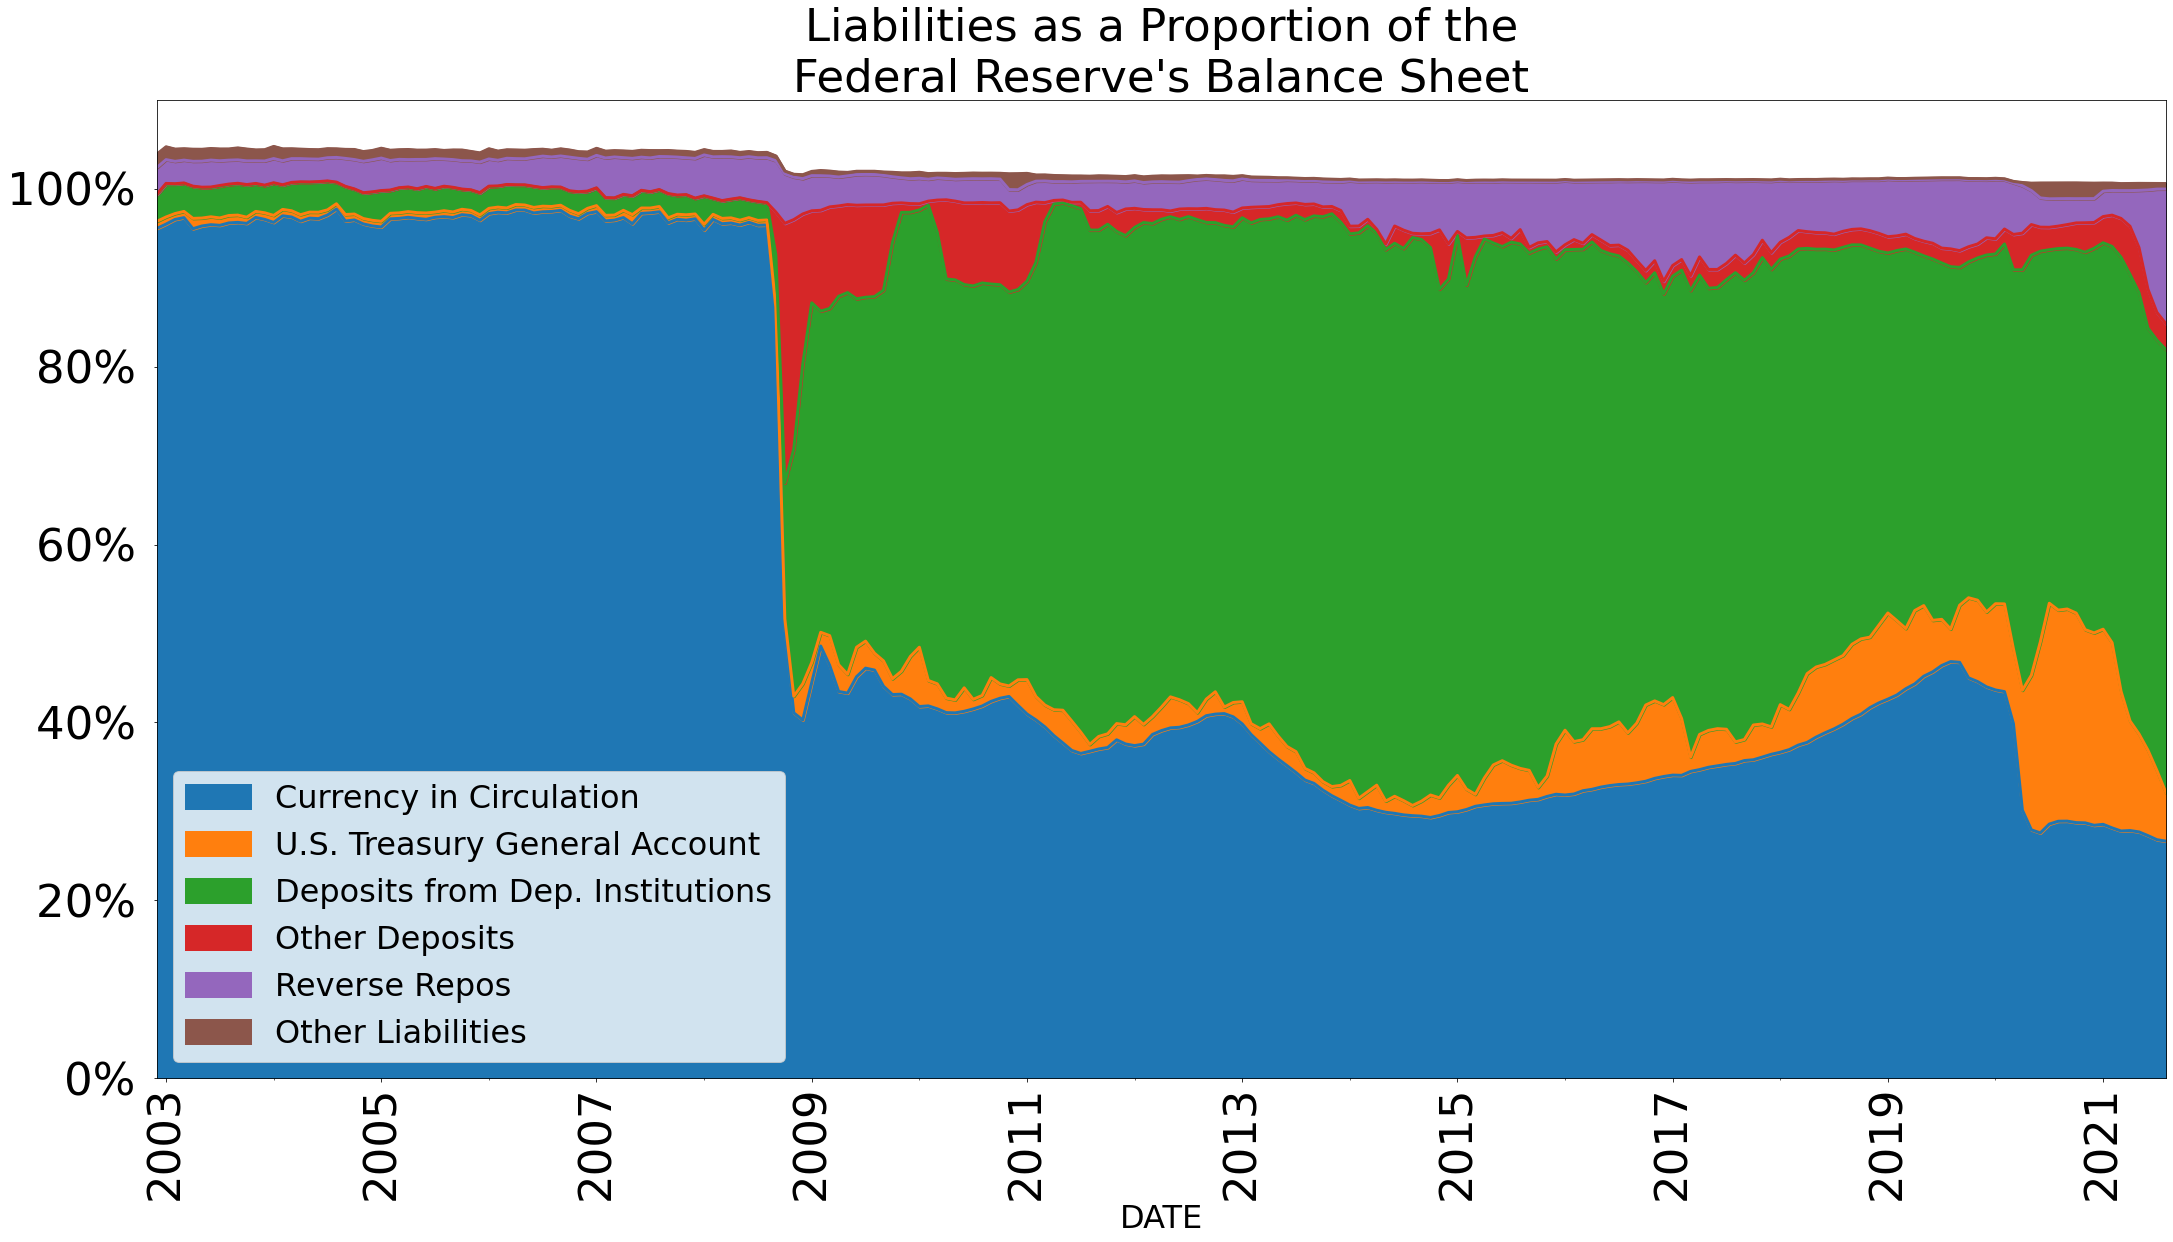

In [9]:
plt.rcParams.update({"font.size":32})
df = plot_data.copy()
for key in account_vars:
    df[key] = df[key].div(df["Total Liabilities"])
figsize= (36,18)
fig, ax = plt.subplots(figsize = figsize)
df[account_vars].plot.area(stacked = True, linewidth = 3,
                            ax = ax)
plt.xticks(rotation= 90, fontsize = 45)
ax.set_yticklabels([str(int(val * 100)) + "% " for val in ax.get_yticks()], fontsize = 45)

#plt.yticks([int(tick * 100) for tick in ax.get_yticks() if tick <1.01])
plt.title("Liabilities as a Proportion of the\nFederal Reserve's Balance Sheet", fontsize =45)
plt.show()


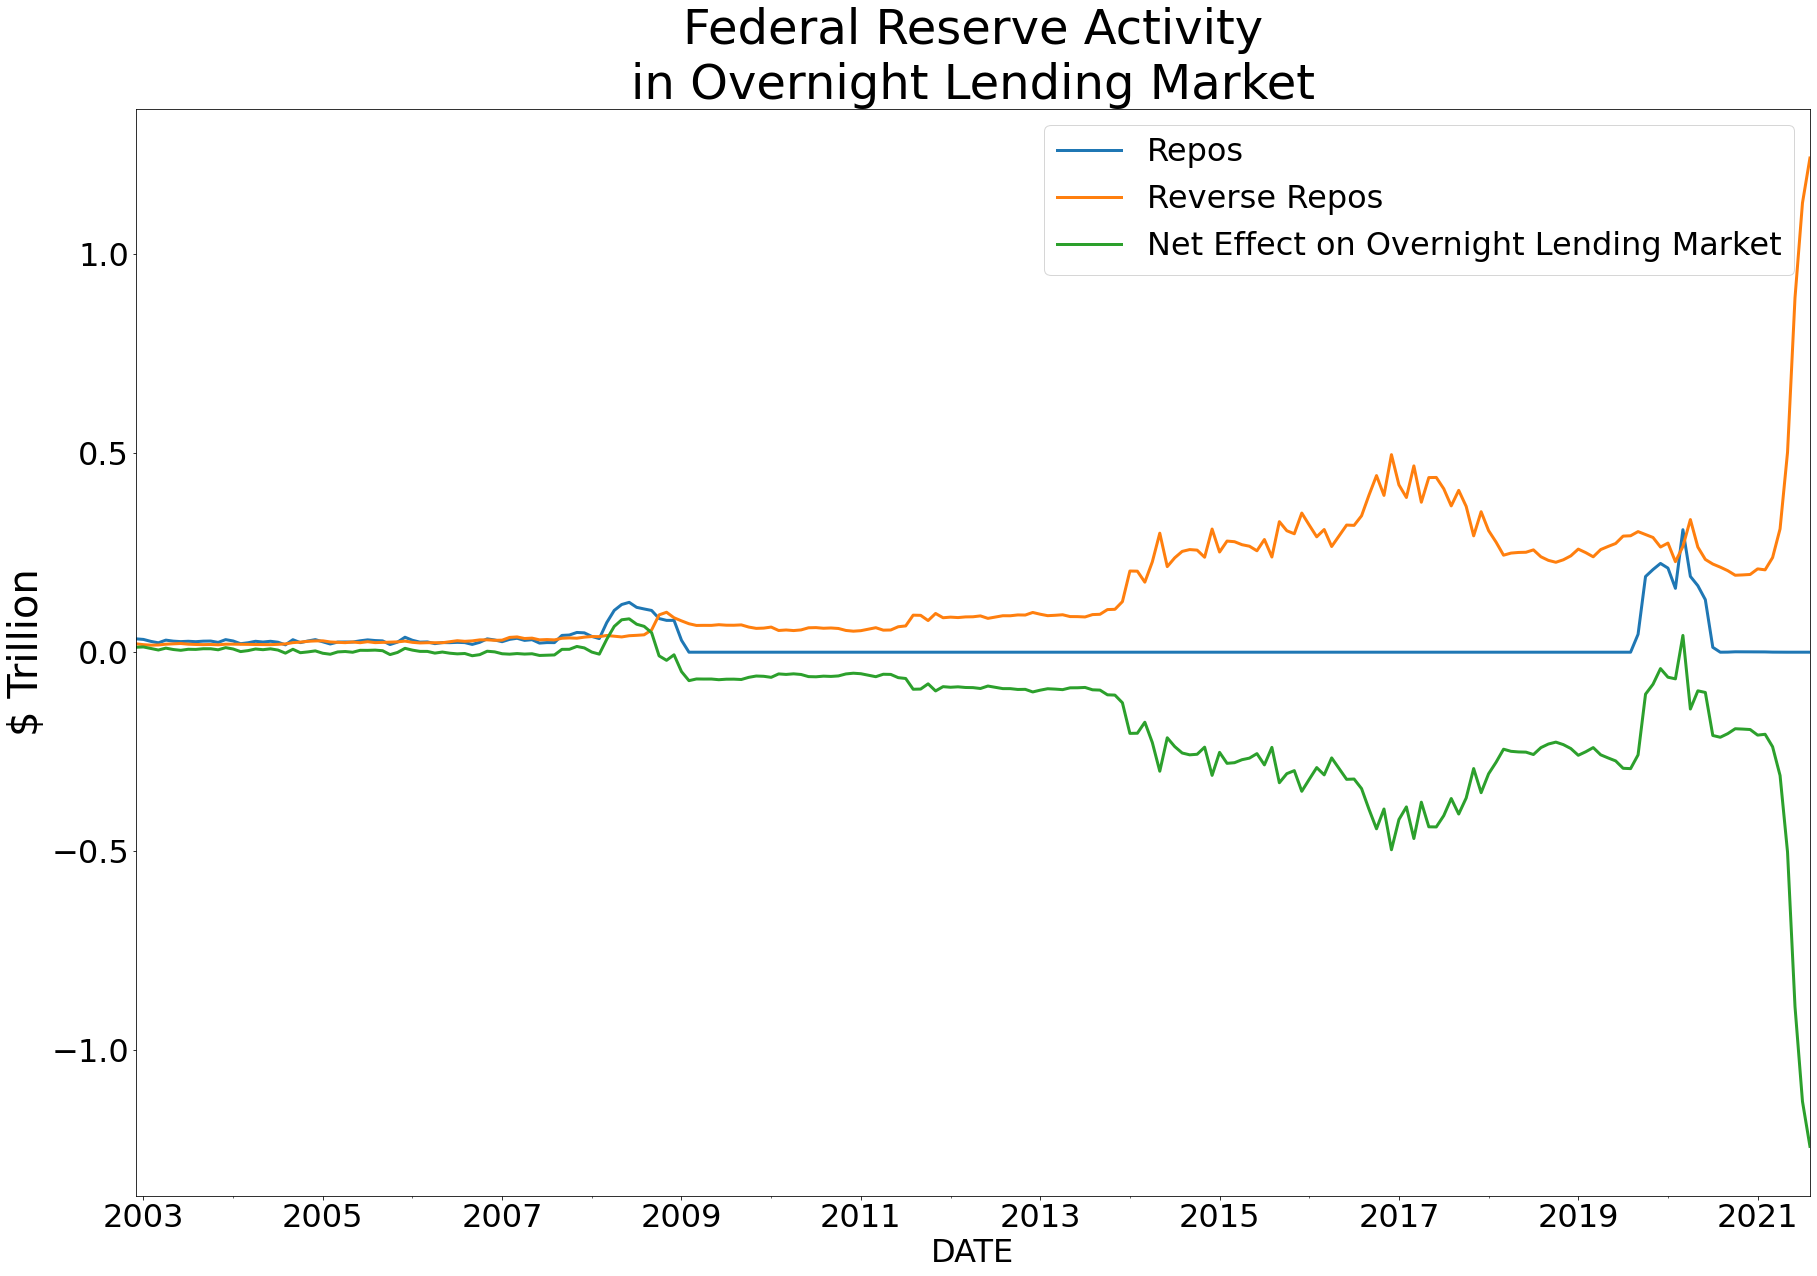

In [10]:
plot_data["Net Effect on Overnight Lending Market"] =\
    plot_data["Repos"].sub(plot_data["Reverse Repos"])
overnight_vars = ["Repos",
                  "Reverse Repos",
                  "Net Effect on Overnight Lending Market"]
fig, ax = plt.subplots(figsize = (30,20))
plot_data[overnight_vars].plot.line(legend=True, linewidth = 3, ax = ax)
ax.set_ylabel("$ Trillion", fontsize = 40)
ax.set_title("Federal Reserve Activity\nin Overnight Lending Market", fontsize = 48)
plot_data[["Date"] + overnight_vars].to_json("overnightLending.json", orient="records")


In [11]:
data["Total Liabilities Growth Rate (%)"] = data["Total Liabilities"].pct_change(year)
data["Total Assets Growth Rate (%)"] = data["Total Assets"].pct_change(year)
data["Total Liabilities / Currency in Circulation"] = data["Total Liabilities"].div(data["Currency in Circulation ($ Bil)"].mul(1000))
data["Total Assets / Currency in Circulation"] = data["Total Assets"].div(data["Currency in Circulation ($ Bil)"].mul(1000))
data["Currency in Circulation / Total Assets"] = data["Currency in Circulation ($ Bil)"].mul(1000).div(data["Total Assets"])
data["Currency in Circulation / Total Assets Diff"] = data["Currency in Circulation / Total Assets"].diff(year)
data["Currency in Circulation / Total Liabilities"] = data["Currency in Circulation ($ Bil)"].mul(1000).div(data["Total Liabilities"])
data["Currency in Circulation / Total Liabilities Diff"] = data["Currency in Circulation / Total Liabilities"].diff(year)

data["Log Total Liabilities"] = np.log(data["Total Liabilities"])
data["Log Total Assets"] = np.log(data["Total Assets"])
#data["Currency in Circulation / Total Liabilities %"] = data["Currency in Circulation / Total Liabilities"].pct_change()
data

,Total Assets,"Balance Sheet Securities, Prem-Disc, Repos, and Loans",Securities Held Outright,U.S. Treasuries Held Outright,Federal Agency Debt Securities,Mortgage-Backed Securities,Repos,Central Bank Liquidity Swaps,Direct Lending,Unamortized Security Premiums,...,Other Assets,Other Liabilities,Total Liabilities Growth Rate (%),Total Assets Growth Rate (%),Total Liabilities / Currency in Circulation,Total Assets / Currency in Circulation,Currency in Circulation / Total Assets,Currency in Circulation / Total Assets Diff,Currency in Circulation / Total Liabilities,Currency in Circulation / Total Liabilities Diff
DATE,,,,,,,,,,,,,,,,,,,,,
2002-12-31,725800.50,672844.50,629409.50,629399.50,10.0,0.00,33625.00,0.00,52.00,10811.00,...,51903.00,10742.50,NaN,NaN,1.046535,1.072920,0.932036,NaN,0.955534,NaN
2003-01-31,724718.40,671196.20,629416.00,629406.00,10.0,0.00,32100.00,0.00,19.40,10688.00,...,52495.00,10218.00,NaN,NaN,1.041374,1.066686,0.937483,NaN,0.960270,NaN
2003-02-28,721326.00,668666.25,631911.75,631901.75,10.0,0.00,27185.50,0.00,10.50,10571.25,...,51647.00,9699.50,NaN,NaN,1.035709,1.061035,0.942476,NaN,0.965522,NaN
2003-03-31,723651.25,672446.00,639168.25,639158.25,10.0,0.00,23625.00,0.00,11.00,10619.25,...,50227.75,9072.00,NaN,NaN,1.033573,1.058878,0.944396,NaN,0.967518,NaN
2003-04-30,736926.40,685518.60,645508.60,645498.60,10.0,0.00,30350.20,0.00,31.80,10574.40,...,50461.40,9784.00,NaN,NaN,1.047029,1.072587,0.932326,NaN,0.955083,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-30,7775974.00,7614925.00,7207246.25,4986900.00,2347.0,2217999.25,0.00,759.75,67584.00,350857.25,...,149526.75,62450.75,0.235993,0.234607,3.590385,3.608609,0.277115,-0.022548,0.278522,-0.023000
2021-05-31,7866893.25,7709974.25,7291913.75,5063447.75,2347.0,2226119.00,11.75,642.50,81423.00,349622.50,...,143279.75,61712.25,0.132997,0.132325,3.610492,3.628665,0.275583,-0.002173,0.276971,-0.002350
2021-06-30,8026555.20,7874851.20,7450341.40,5149903.00,2347.0,2298091.20,0.00,516.00,87694.60,350797.60,...,137205.60,59004.00,0.126694,0.126094,3.665537,3.683695,0.271467,-0.002864,0.272811,-0.003025


In [12]:
import pingouin
plot_vars = ["Inflation (PCE)",
             "Unemployment Rate",
             "Inflation Loss",
             "Unemployment Loss",
             "Linear Loss",
             "Loss Function",
             "Effective Federal Funds Rate (%)",
             "Currency in Circulation Growth Rate (%)",
             "Currency in Circulation / Total Liabilities",
             "Total Assets Growth Rate (%)"]
#data[plot_vars].describe().T.to_excel("C:\\Users\\JLCat\\OneDrive\\Documents\\For NDSU\\Projects\\Sound Money Project\\Frederal Reserve QE Framework\\DescriptionStatistics.xls")
#data[plot_vars].describe().corr()
#data[plot_vars].describe().pcorr()

C:\ProgramData\Anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.4.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [13]:
plot_vars = [#Currency in Circulation Growth Rate (%)",
             #"Currency not in Circulation Growth Rate (%)",
             #"5 Year Forward Rate",
             #"Inflation (CPI)",
             #"Unemployment Rate Diff",
             #"Loss Function Diff",
            #"Unemployment Loss Diff",
            #"Inflation Loss Diff",
            #"Linear Loss Diff",
            #"Unemployment Loss Sq Diff",
            #"Inflation Loss Sq Diff",
            "Linear Loss Diff",
    #"Currency in Circulation % Change Velocity",
             #"Nominal GDP Growth Rate (%)",
             #"Real GDP Growth Rate (%)",
             "Effective Federal Funds Rate Diff (%)",
             #"30 Year Treasury Rate (%)",
             #"1 Month Treasury Rate (%)",
             #"S&P Growth Rate (%)",
             "Currency in Circulation / Total Liabilities Diff",
             #Total Assets Growth Rate (%)",
             "VIX Diff"
]
dag_df = data[plot_vars].dropna().rename(columns={key: key.replace(" ", "\n") for key in plot_vars}).loc["2008-10-01":"2020-08-01"]
dag_df.pcorr().round(2)

,Linear\nLoss\nDiff,Effective\nFederal\nFunds\nRate\nDiff\n(%),Currency\nin\nCirculation\n/\nTotal\nLiabilities\nDiff,VIX\nDiff
Linear\nLoss\nDiff,1.00,0.29,0.29,0.11
Effective\nFederal\nFunds\nRate\nDiff\n(%),0.29,1.00,0.68,-0.26
Currency\nin\nCirculation\n/\nTotal\nLiabilities\nDiff,0.29,0.68,1.00,-0.08
VIX\nDiff,0.11,-0.26,-0.08,1.00


Working for n conditional variables: 1: 100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 71.59it/s]C:\ProgramData\Anaconda3\lib\site-packages\pgmpy\estimators\PC.py:369: UserWarning: Reached maximum number of allowed conditional variables. Exiting
  warn("Reached maximum number of allowed conditional variables. Exiting")
Working for n conditional variables: 1: 100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 13.93it/s]


('Currency\nin\nCirculation\n/\nTotal\nAssets\nDiff', 'Linear\nLoss\nDiff') : 0.2860745927439227
('Effective\nFederal\nFunds\nRate\nDiff\n(%)', 'Linear\nLoss\nDiff') : 0.26228203576049874
('Effective\nFederal\nFunds\nRate\nDiff\n(%)', 'Currency\nin\nCirculation\n/\nTotal\nAssets\nDiff') : 0.7342332299250681


Working for n conditional variables: 1: 100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 111.40it/s]C:\ProgramData\Anaconda3\lib\site-packages\pgmpy\estimators\PC.py:369: UserWarning: Reached maximum number of allowed conditional variables. Exiting
  warn("Reached maximum number of allowed conditional variables. Exiting")
Working for n conditional variables: 1:  50%|██████████████████████                      | 1/2 [00:00<00:00, 93.83it/s]

('Effective\nFederal\nFunds\nRate\nDiff\n(%)', 'Currency\nin\nCirculation\n/\nTotal\nAssets\nDiff') : 0.6077157216086935


Working for n conditional variables: 2: 100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 14.25it/s]C:\ProgramData\Anaconda3\lib\site-packages\pgmpy\estimators\PC.py:369: UserWarning: Reached maximum number of allowed conditional variables. Exiting
  warn("Reached maximum number of allowed conditional variables. Exiting")
Working for n conditional variables: 2: 100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 11.35it/s]
C:\ProgramData\Anaconda3\lib\site-packages\pgmpy\base\DAG.py:1188: UserWarning: PDAG has no faithful extension (= no oriented DAG with the same v-structures as PDAG). Remaining undirected PDAG edges oriented arbitrarily.
  warn(
Working for n conditional variables: 2: 100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 14.64it/s]


('Total\nAssets\nGrowth\nRate\n(%)', 'Linear\nLoss\nDiff') : -0.24632789098500327
('Linear\nLoss\nDiff', 'Effective\nFederal\nFunds\nRate\nDiff\n(%)') : 0.23576034425377182
('Currency\nin\nCirculation\nGrowth\nRate\n(%)', 'Total\nAssets\nGrowth\nRate\n(%)') : 0.28789194301368437
('Effective\nFederal\nFunds\nRate\nDiff\n(%)', 'Total\nAssets\nGrowth\nRate\n(%)') : -0.7620495104721875


Working for n conditional variables: 2: 100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 35.15it/s]C:\ProgramData\Anaconda3\lib\site-packages\pgmpy\estimators\PC.py:369: UserWarning: Reached maximum number of allowed conditional variables. Exiting
  warn("Reached maximum number of allowed conditional variables. Exiting")
Working for n conditional variables: 1:  50%|██████████████████████                      | 1/2 [00:00<00:00, 83.54it/s]

('Currency\nin\nCirculation\nGrowth\nRate\n(%)', 'Effective\nFederal\nFunds\nRate\nDiff\n(%)') : 0.8218844112915875
('Total\nAssets\nGrowth\nRate\n(%)', 'Effective\nFederal\nFunds\nRate\nDiff\n(%)') : -0.1741954476855914
('Total\nAssets\nGrowth\nRate\n(%)', 'Currency\nin\nCirculation\nGrowth\nRate\n(%)') : 0.558709855522524


Working for n conditional variables: 2: 100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 16.57it/s]C:\ProgramData\Anaconda3\lib\site-packages\pgmpy\estimators\PC.py:369: UserWarning: Reached maximum number of allowed conditional variables. Exiting
  warn("Reached maximum number of allowed conditional variables. Exiting")
Working for n conditional variables: 2: 100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 13.37it/s]


('Currency\nin\nCirculation\n/\nTotal\nAssets\nDiff', 'Effective\nFederal\nFunds\nRate\nDiff\n(%)') : 0.7583501316136194
('Effective\nFederal\nFunds\nRate\nDiff\n(%)', 'Unemployment\nLoss\nDiff') : -0.42362255359404133
('Inflation\nLoss\nDiff', 'Currency\nin\nCirculation\n/\nTotal\nAssets\nDiff') : 0.39268688285101455


Working for n conditional variables: 2: 100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 29.93it/s]C:\ProgramData\Anaconda3\lib\site-packages\pgmpy\estimators\PC.py:369: UserWarning: Reached maximum number of allowed conditional variables. Exiting
  warn("Reached maximum number of allowed conditional variables. Exiting")
Working for n conditional variables: 0:   0%|                                                    | 0/3 [00:00<?, ?it/s]

('Inflation\nLoss\nDiff', 'Unemployment\nLoss\nDiff') : 0.4629820037275179
('Effective\nFederal\nFunds\nRate\nDiff\n(%)', 'Unemployment\nLoss\nDiff') : -0.9203695707962215


Working for n conditional variables: 3: 100%|████████████████████████████████████████████| 3/3 [00:00<00:00,  7.81it/s]C:\ProgramData\Anaconda3\lib\site-packages\pgmpy\estimators\PC.py:369: UserWarning: Reached maximum number of allowed conditional variables. Exiting
  warn("Reached maximum number of allowed conditional variables. Exiting")
Working for n conditional variables: 1:  33%|██████████████▋                             | 1/3 [00:00<00:00, 58.97it/s]

('Total\nAssets\nGrowth\nRate\n(%)', 'Inflation\nLoss\nDiff') : -0.28528985759056186
('Currency\nin\nCirculation\nGrowth\nRate\n(%)', 'Total\nAssets\nGrowth\nRate\n(%)') : 0.28042491458291335
('Effective\nFederal\nFunds\nRate\nDiff\n(%)', 'Total\nAssets\nGrowth\nRate\n(%)') : -0.7675774582886082
('Unemployment\nLoss\nDiff', 'Effective\nFederal\nFunds\nRate\nDiff\n(%)') : -0.3411954161923072


Working for n conditional variables: 3: 100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 25.27it/s]


('Effective\nFederal\nFunds\nRate\nDiff\n(%)', 'Unemployment\nLoss\nDiff') : -0.7810998348511248
('Currency\nin\nCirculation\nGrowth\nRate\n(%)', 'Effective\nFederal\nFunds\nRate\nDiff\n(%)') : 0.47737136278367104
('Unemployment\nLoss\nDiff', 'Inflation\nLoss\nDiff') : 0.38944242799067236
('Total\nAssets\nGrowth\nRate\n(%)', 'Currency\nin\nCirculation\nGrowth\nRate\n(%)') : 0.5563566494171939


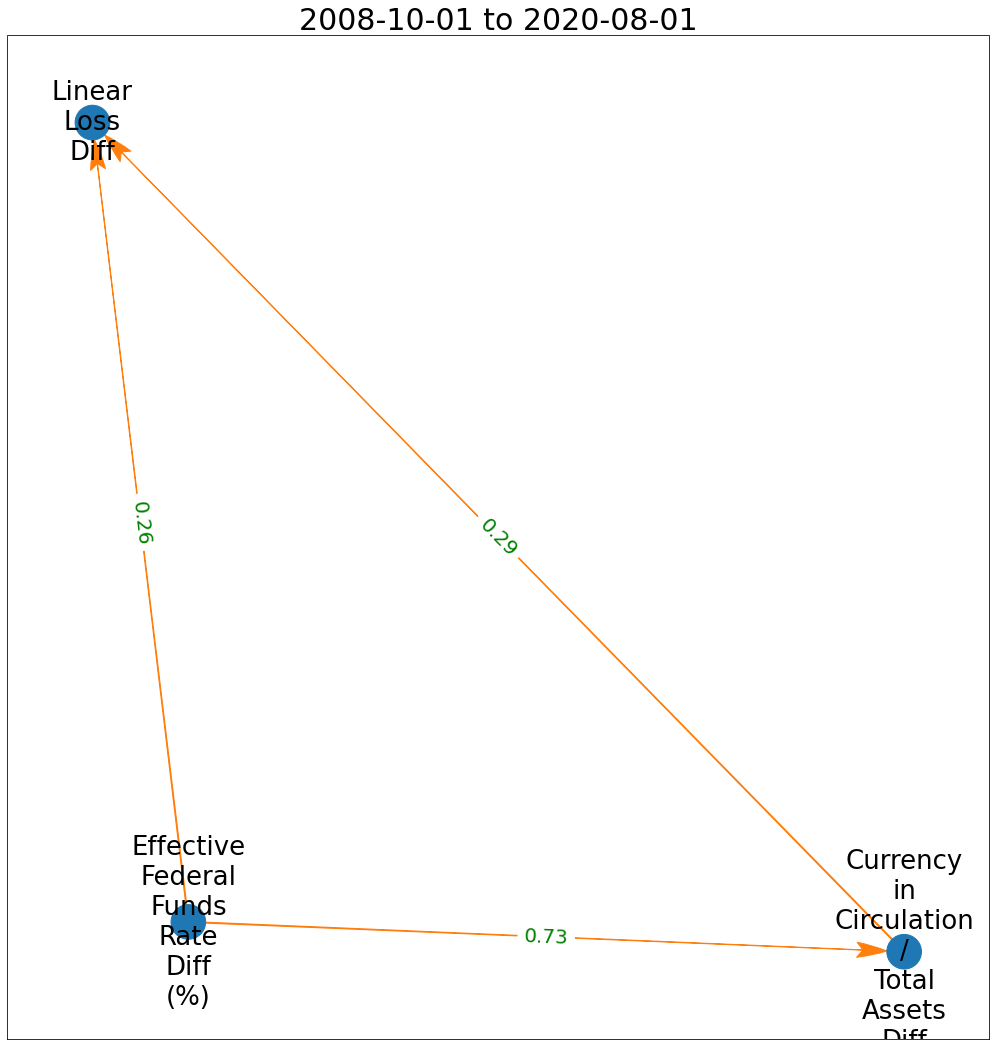

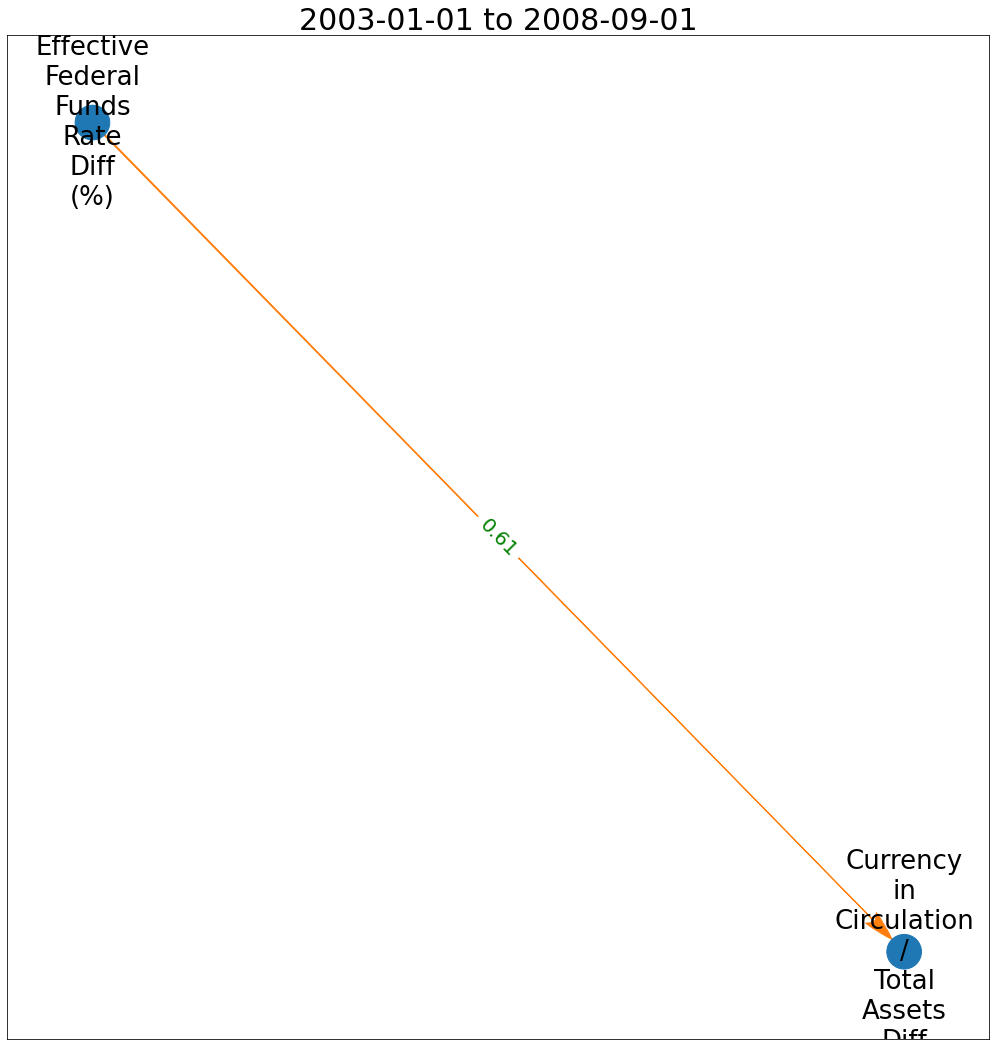

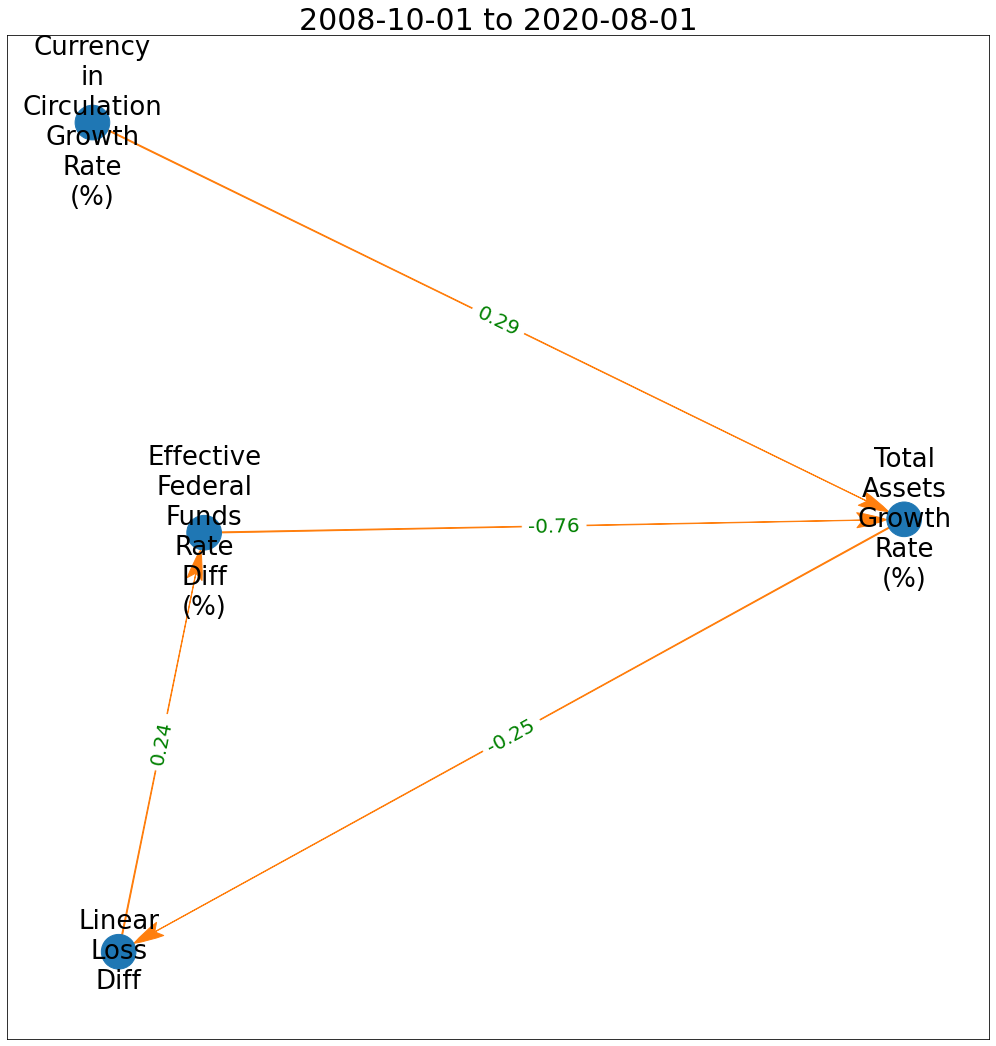

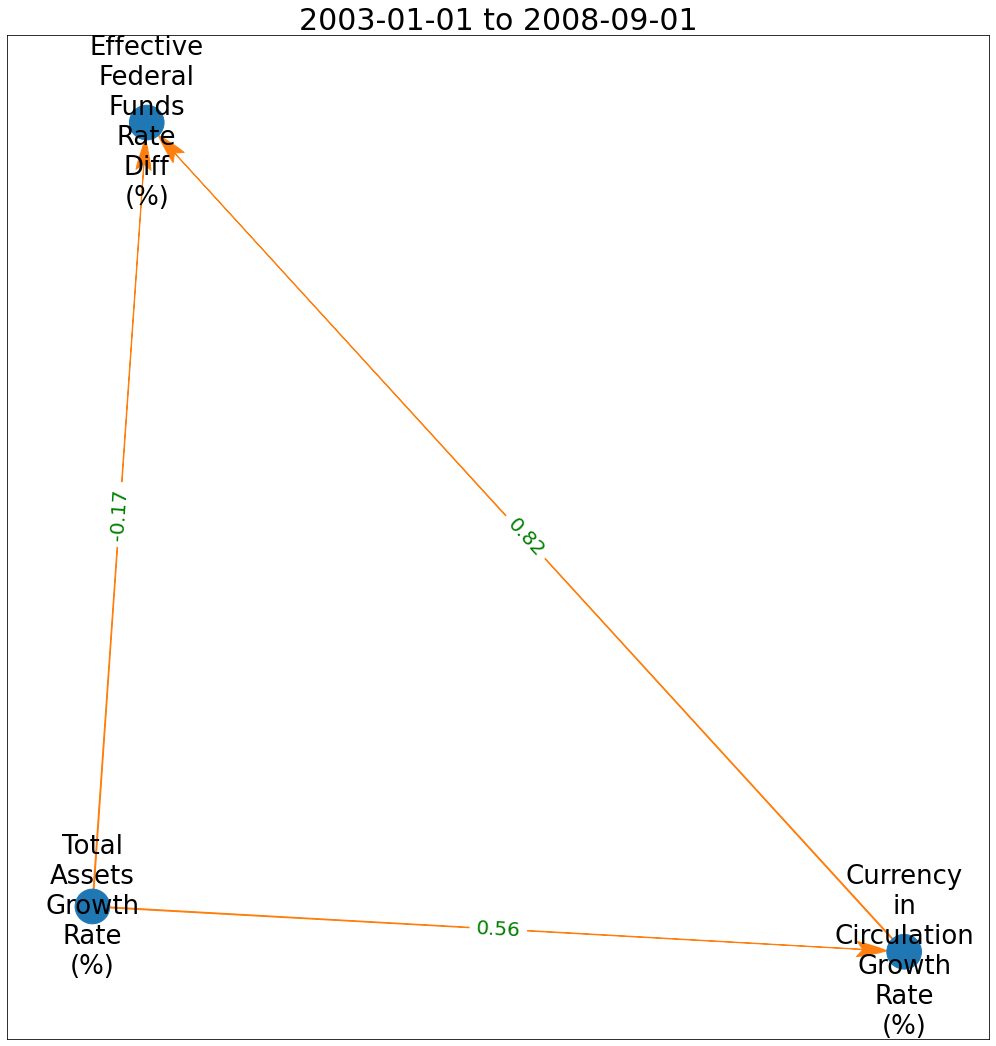

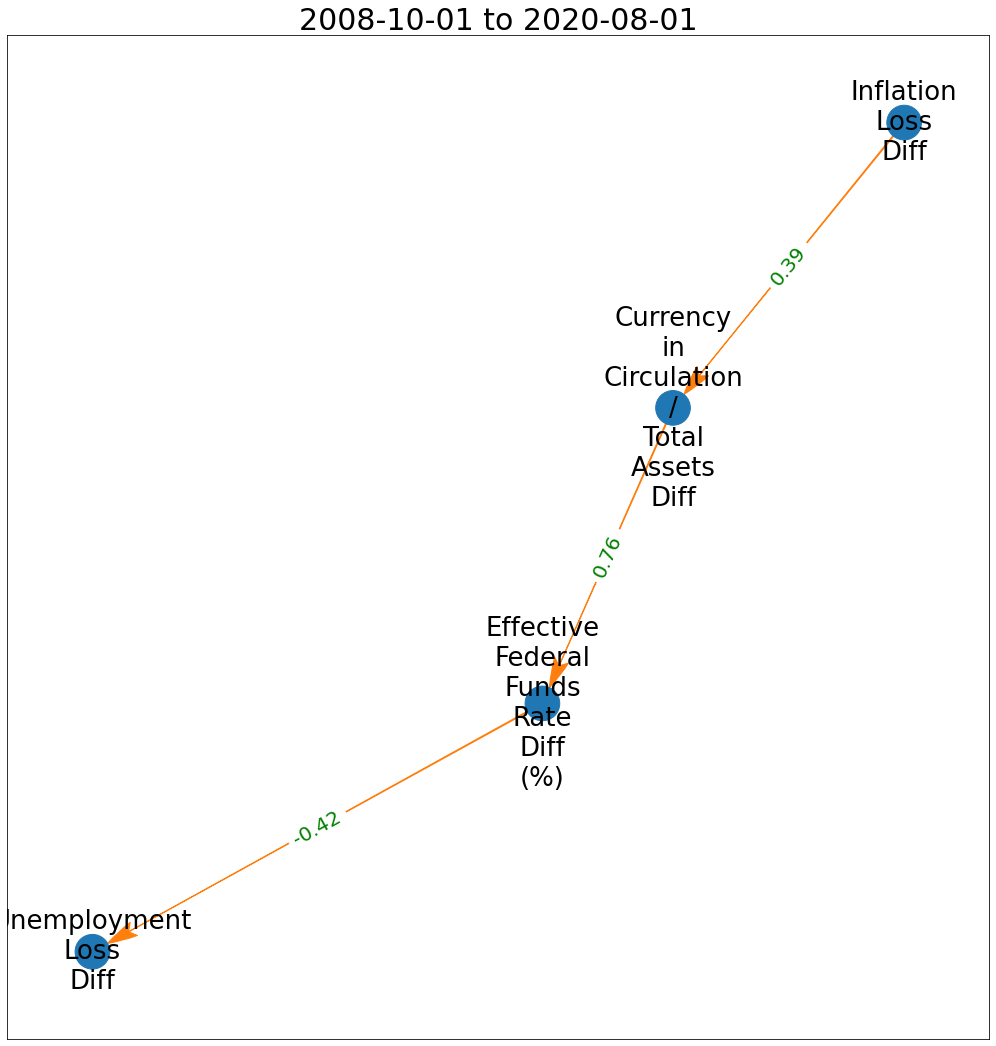

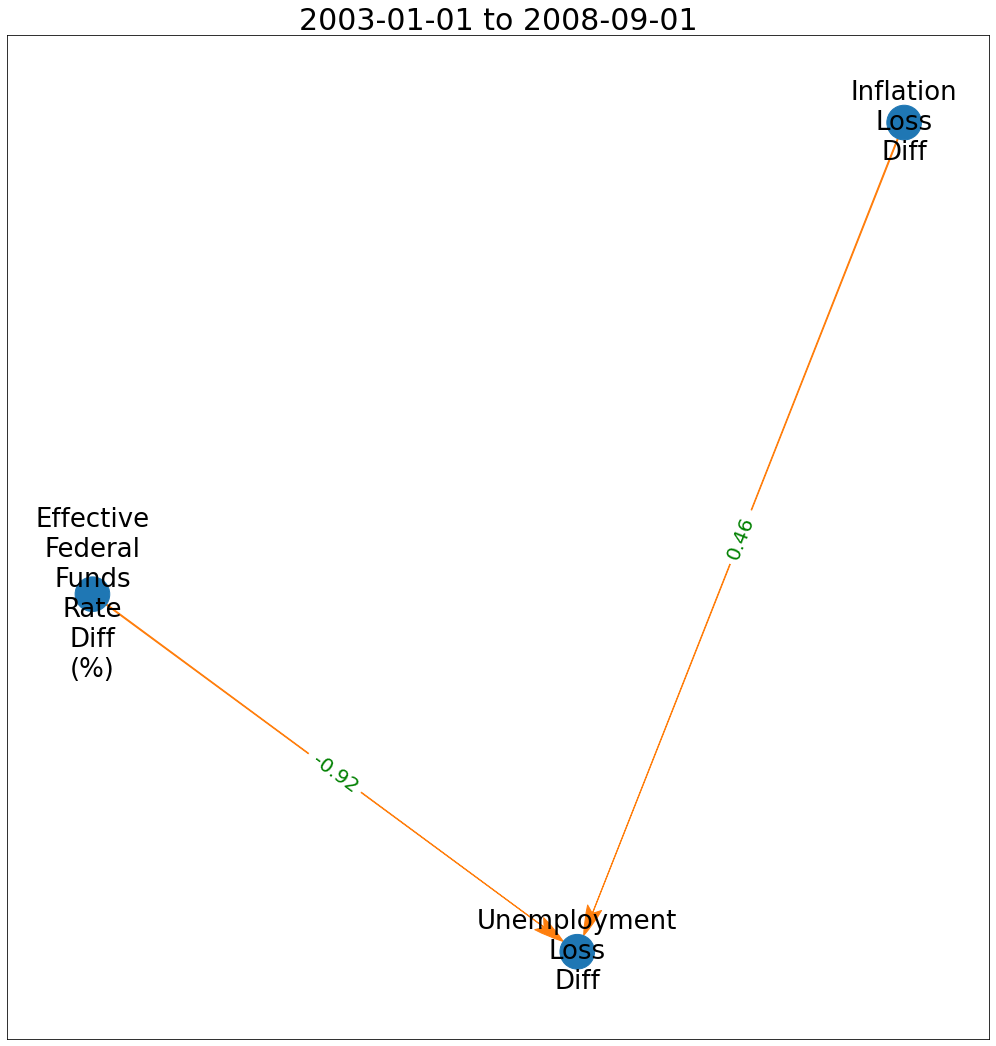

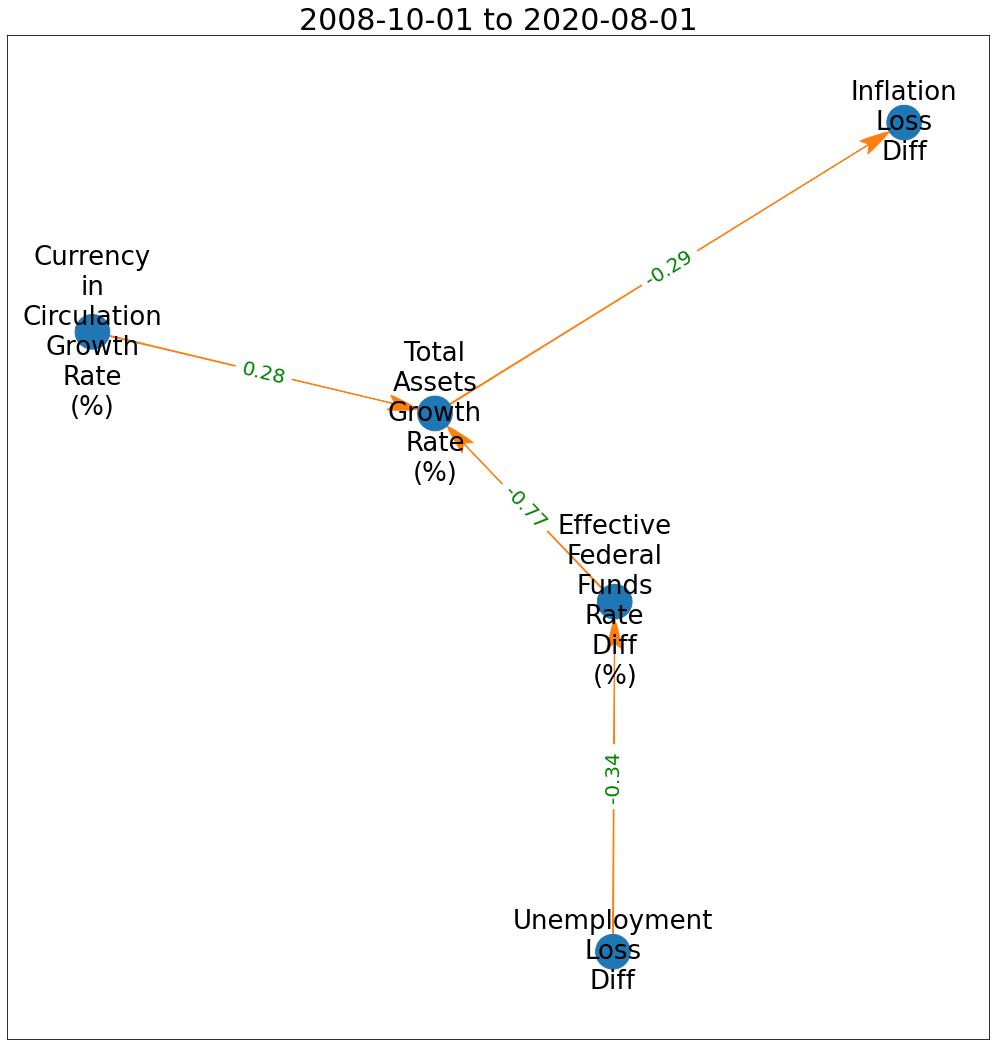

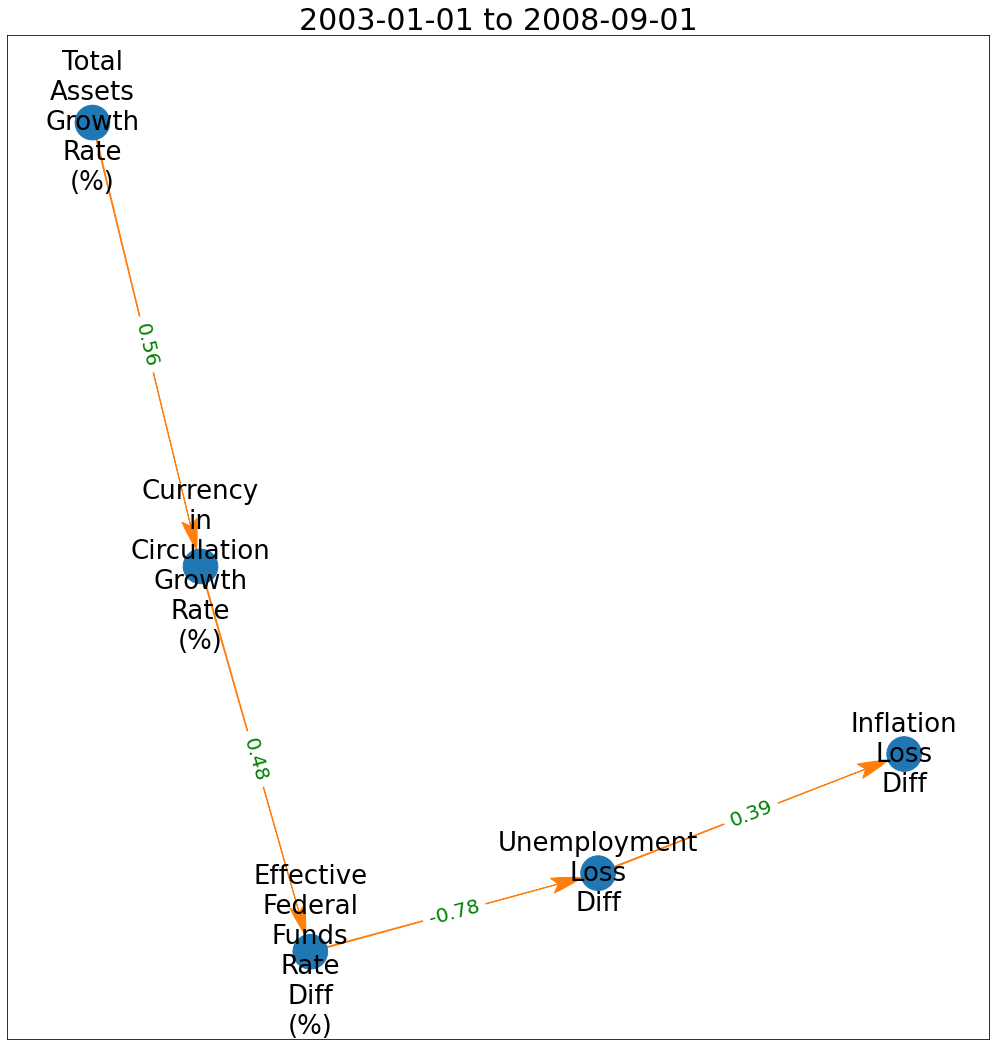

In [14]:
from pgmpy.estimators import PC
from pgmpy.base import DAG
import matplotlib.pyplot as plt
from matplotlib.patches import ArrowStyle
import networkx as nx
plt.rcParams.update({"font.size":20})

def graph_DAG(edges, df, title = ""):
    pcorr = df.pcorr()
    graph = nx.DiGraph()
    edge_labels = {}
    for edge in edges:
        edge_labels[edge] = str(round(pcorr[edge[0]].loc[edge[1]],2))
        
    graph.add_edges_from(edges)
    color_map = ["C0" for g in graph]

    fig, ax = plt.subplots(figsize = (15,15))
    graph.nodes()
    plt.tight_layout()
    pos = nx.spring_layout(graph)#, k = 5/(len(sig_corr.keys())**.5))

    plt.title(title, fontsize = 30)
    nx.draw_networkx(graph, pos, node_color=color_map, node_size = 1200,
                     with_labels=True,  arrows=True,
                     #font_color = "white",
                     font_size = 26, alpha = 1,
                     width = 1, edge_color = "C1",
                     arrowstyle=ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"), ax = ax)
    nx.draw_networkx_edge_labels(graph,pos,
                                 edge_labels=edge_labels,
                                 font_color='green',
                                 font_size=20)
    
plot_vars_dct = {0: ["Linear Loss Diff",
                     "Effective Federal Funds Rate Diff (%)",
                     "Currency in Circulation / Total Assets Diff"],
#                     "VIX Diff"],
                 1:["Currency in Circulation Growth Rate (%)",
                    "Linear Loss Diff",
                    "Effective Federal Funds Rate Diff (%)",
                    "Total Assets Growth Rate (%)"],
 #                   "VIX Diff"],
                 2:["Unemployment Loss Diff",
                    "Inflation Loss Diff",
                    "Effective Federal Funds Rate Diff (%)",
                    "Currency in Circulation / Total Assets Diff"],
#                    "VIX Diff"],
                 3:["Currency in Circulation Growth Rate (%)",
                    "Unemployment Loss Diff",
                    "Inflation Loss Diff",
                    "Effective Federal Funds Rate Diff (%)",
                    "Total Assets Growth Rate (%)"],
                    #"VIX Diff"]
}

sig = 0.05
variant = "parallel"
ci_test = "pearsonr"
for key, plot_vars in plot_vars_dct.items():
    dfs = {"2008-10-01 to 2020-08-01": data[plot_vars].dropna().rename(columns={key: key.replace(" ", "\n") for key in plot_vars}).loc["2008-10-01":"2020-08-01"],
           "2003-01-01 to 2008-09-01": data[plot_vars].dropna().rename(columns={key: key.replace(" ", "\n") for key in plot_vars}).loc[:"2008-09-01"]}
           
    for dates, dag_df in dfs.items():

        keys = dag_df.keys()
        c = PC(dag_df.dropna())
        max_cond_vars = len(keys) - 2


        model = c.estimate(return_type = "dag",variant= variant, 
                           significance_level = sig, 
                           max_cond_vars = max_cond_vars, ci_test = ci_test)

        edges = model.edges()
        pcorr = dag_df.pcorr()
        weights = {}
        for edge in edges:
            print(edge, ":",pcorr[edge[0]].loc[edge[1]])
        skel, sep_sets = c.build_skeleton(variant = variant, ci_test = ci_test, significance_level = 0.01, 
                           max_cond_vars = max_cond_vars)


        graph_DAG(edges, dag_df, title = dates)

In [15]:
from pgmpy.estimators import PC
from pgmpy.base import DAG

keys = dag_df.keys()
c = PC(dag_df.dropna())
max_cond_vars = len(keys) - 2

sig = 0.05
variant = "parallel"
ci_test = "pearsonr"
model = c.estimate(return_type = "dag",variant= variant, 
                   significance_level = sig, 
                   max_cond_vars = max_cond_vars, ci_test = ci_test)

edges = model.edges()
pcorr = dag_df.pcorr()
weights = {}
for edge in edges:
    print(edge, ":",pcorr[edge[0]].loc[edge[1]])
skel, sep_sets = c.build_skeleton(variant = variant, ci_test = ci_test, significance_level = 0.01, 
                   max_cond_vars = max_cond_vars)
sep_sets

Working for n conditional variables: 3: 100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 23.72it/s]

('Effective\nFederal\nFunds\nRate\nDiff\n(%)', 'Unemployment\nLoss\nDiff') : -0.7810998348511248
('Currency\nin\nCirculation\nGrowth\nRate\n(%)', 'Effective\nFederal\nFunds\nRate\nDiff\n(%)') : 0.47737136278367104
('Unemployment\nLoss\nDiff', 'Inflation\nLoss\nDiff') : 0.38944242799067236
('Total\nAssets\nGrowth\nRate\n(%)', 'Currency\nin\nCirculation\nGrowth\nRate\n(%)') : 0.5563566494171939


{frozenset({'Currency\nin\nCirculation\nGrowth\nRate\n(%)',
            'Inflation\nLoss\nDiff'}): (),
 frozenset({'Inflation\nLoss\nDiff', 'Total\nAssets\nGrowth\nRate\n(%)'}): (),
 frozenset({'Currency\nin\nCirculation\nGrowth\nRate\n(%)',
            'Unemployment\nLoss\nDiff'}): ('Effective\nFederal\nFunds\nRate\nDiff\n(%)',),
 frozenset({'Total\nAssets\nGrowth\nRate\n(%)',
            'Unemployment\nLoss\nDiff'}): ('Effective\nFederal\nFunds\nRate\nDiff\n(%)',),
 frozenset({'Effective\nFederal\nFunds\nRate\nDiff\n(%)',
            'Inflation\nLoss\nDiff'}): ('Unemployment\nLoss\nDiff',),
 frozenset({'Effective\nFederal\nFunds\nRate\nDiff\n(%)',
            'Total\nAssets\nGrowth\nRate\n(%)'}): ('Unemployment\nLoss\nDiff',)}

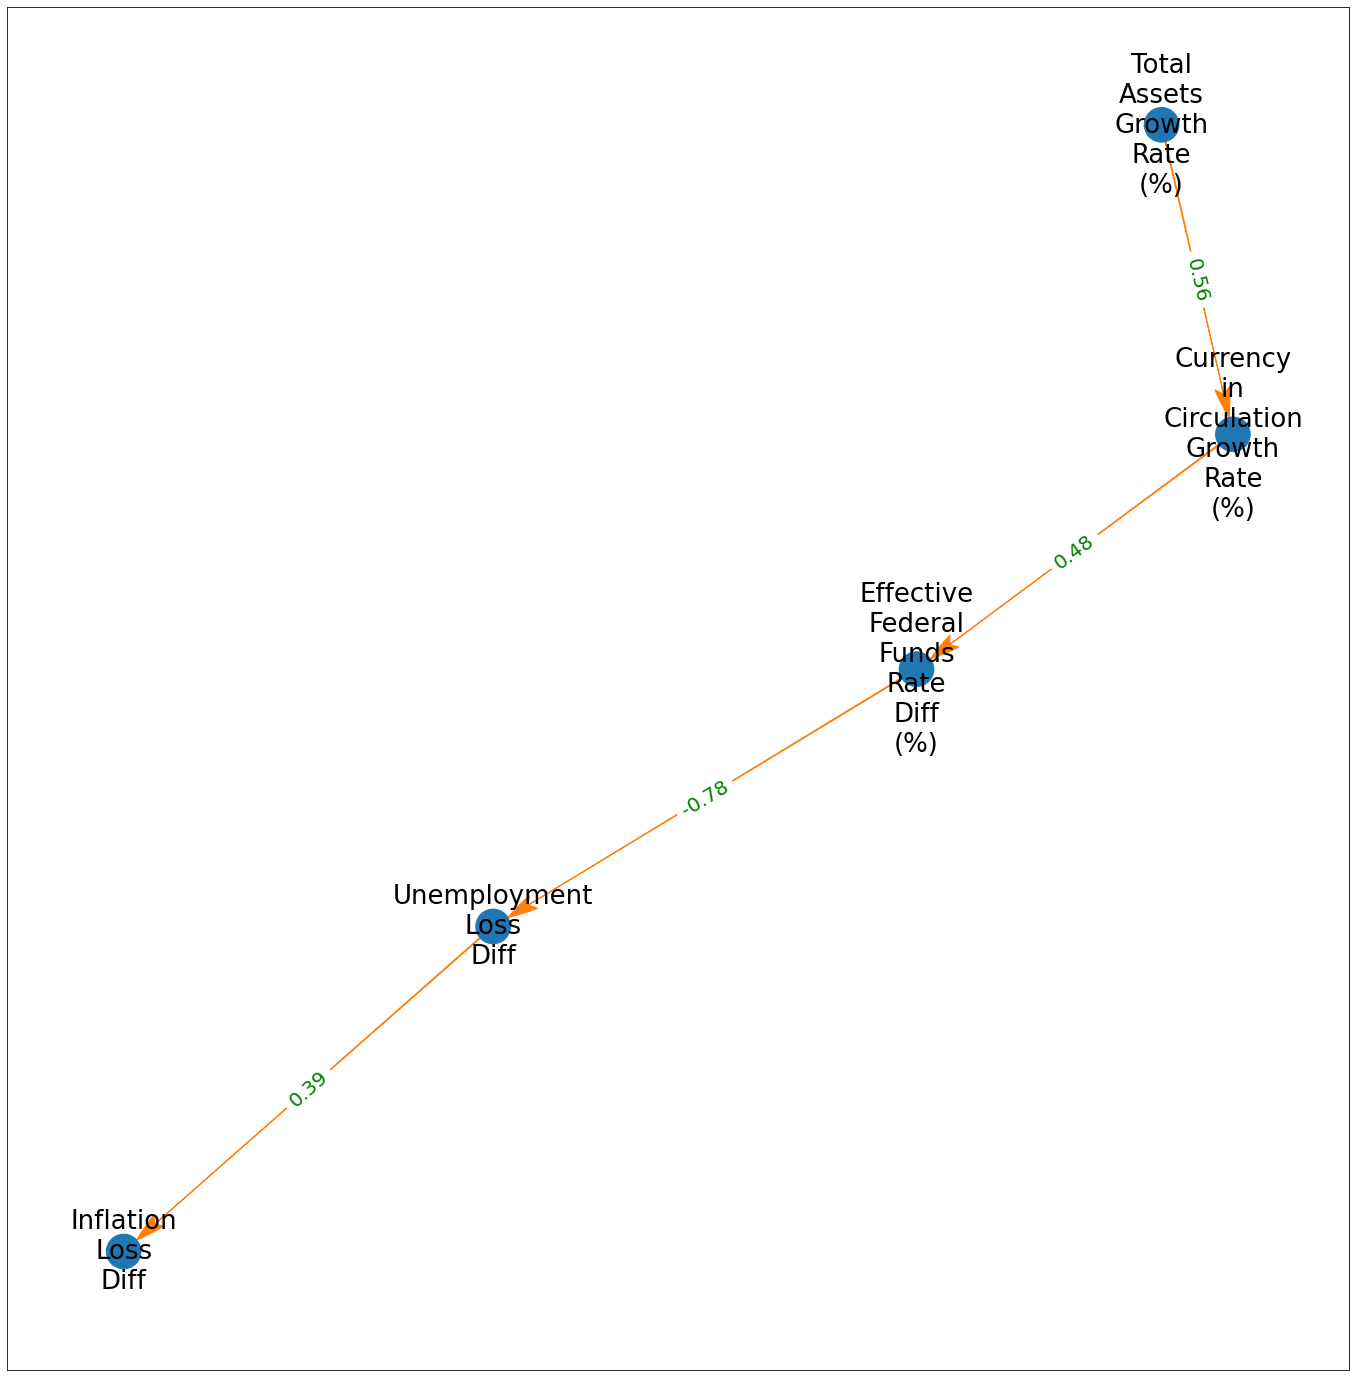

In [16]:
import matplotlib.pyplot as plt
from matplotlib.patches import ArrowStyle
import networkx as nx
plt.rcParams.update({"font.size":20})

def graph_DAG(edges, df, title = ""):
    pcorr = df.pcorr()
    graph = nx.DiGraph()
    edge_labels = {}
    for edge in edges:
        edge_labels[edge] = str(round(pcorr[edge[0]].loc[edge[1]],2))
        
    graph.add_edges_from(edges)
    color_map = ["C0" for g in graph]

    fig, ax = plt.subplots(figsize = (20,20))
    graph.nodes()
    plt.tight_layout()
    pos = nx.spring_layout(graph)#, k = 5/(len(sig_corr.keys())**.5))

    plt.title(title, fontsize = 30)
    nx.draw_networkx(graph, pos, node_color=color_map, node_size = 1200,
                     with_labels=True,  arrows=True,
                     #font_color = "white",
                     font_size = 26, alpha = 1,
                     width = 1, edge_color = "C1",
                     arrowstyle=ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"), ax = ax)
    nx.draw_networkx_edge_labels(graph,pos,
                                 edge_labels=edge_labels,
                                 font_color='green',
                                 font_size=20)

graph_DAG(edges, dag_df)

In [17]:
from pgmpy.estimators import PC
from pgmpy.base import DAG

keys = dag_df.keys()
c = PC(dag_df.dropna())
max_cond_vars = len(keys) - 2

variant = "parallel"
ci_test = "pearsonr"
model = c.estimate(return_type = "dag",variant= variant, 
                   significance_level = sig, 
                   max_cond_vars = max_cond_vars, ci_test = ci_test)

edges = model.edges()
pcorr = dag_df.pcorr()
weights = {}
for edge in edges:
    print(edge, ":",pcorr[edge[0]].loc[edge[1]])
skel, sep_sets = c.build_skeleton(variant = variant, ci_test = ci_test, significance_level = 0.01, 
                   max_cond_vars = max_cond_vars)
sep_sets

Working for n conditional variables: 3: 100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 24.75it/s]

('Effective\nFederal\nFunds\nRate\nDiff\n(%)', 'Unemployment\nLoss\nDiff') : -0.7810998348511248
('Currency\nin\nCirculation\nGrowth\nRate\n(%)', 'Effective\nFederal\nFunds\nRate\nDiff\n(%)') : 0.47737136278367104
('Unemployment\nLoss\nDiff', 'Inflation\nLoss\nDiff') : 0.38944242799067236
('Total\nAssets\nGrowth\nRate\n(%)', 'Currency\nin\nCirculation\nGrowth\nRate\n(%)') : 0.5563566494171939


{frozenset({'Currency\nin\nCirculation\nGrowth\nRate\n(%)',
            'Inflation\nLoss\nDiff'}): (),
 frozenset({'Inflation\nLoss\nDiff', 'Total\nAssets\nGrowth\nRate\n(%)'}): (),
 frozenset({'Currency\nin\nCirculation\nGrowth\nRate\n(%)',
            'Unemployment\nLoss\nDiff'}): ('Effective\nFederal\nFunds\nRate\nDiff\n(%)',),
 frozenset({'Total\nAssets\nGrowth\nRate\n(%)',
            'Unemployment\nLoss\nDiff'}): ('Effective\nFederal\nFunds\nRate\nDiff\n(%)',),
 frozenset({'Effective\nFederal\nFunds\nRate\nDiff\n(%)',
            'Inflation\nLoss\nDiff'}): ('Unemployment\nLoss\nDiff',),
 frozenset({'Effective\nFederal\nFunds\nRate\nDiff\n(%)',
            'Total\nAssets\nGrowth\nRate\n(%)'}): ('Unemployment\nLoss\nDiff',)}

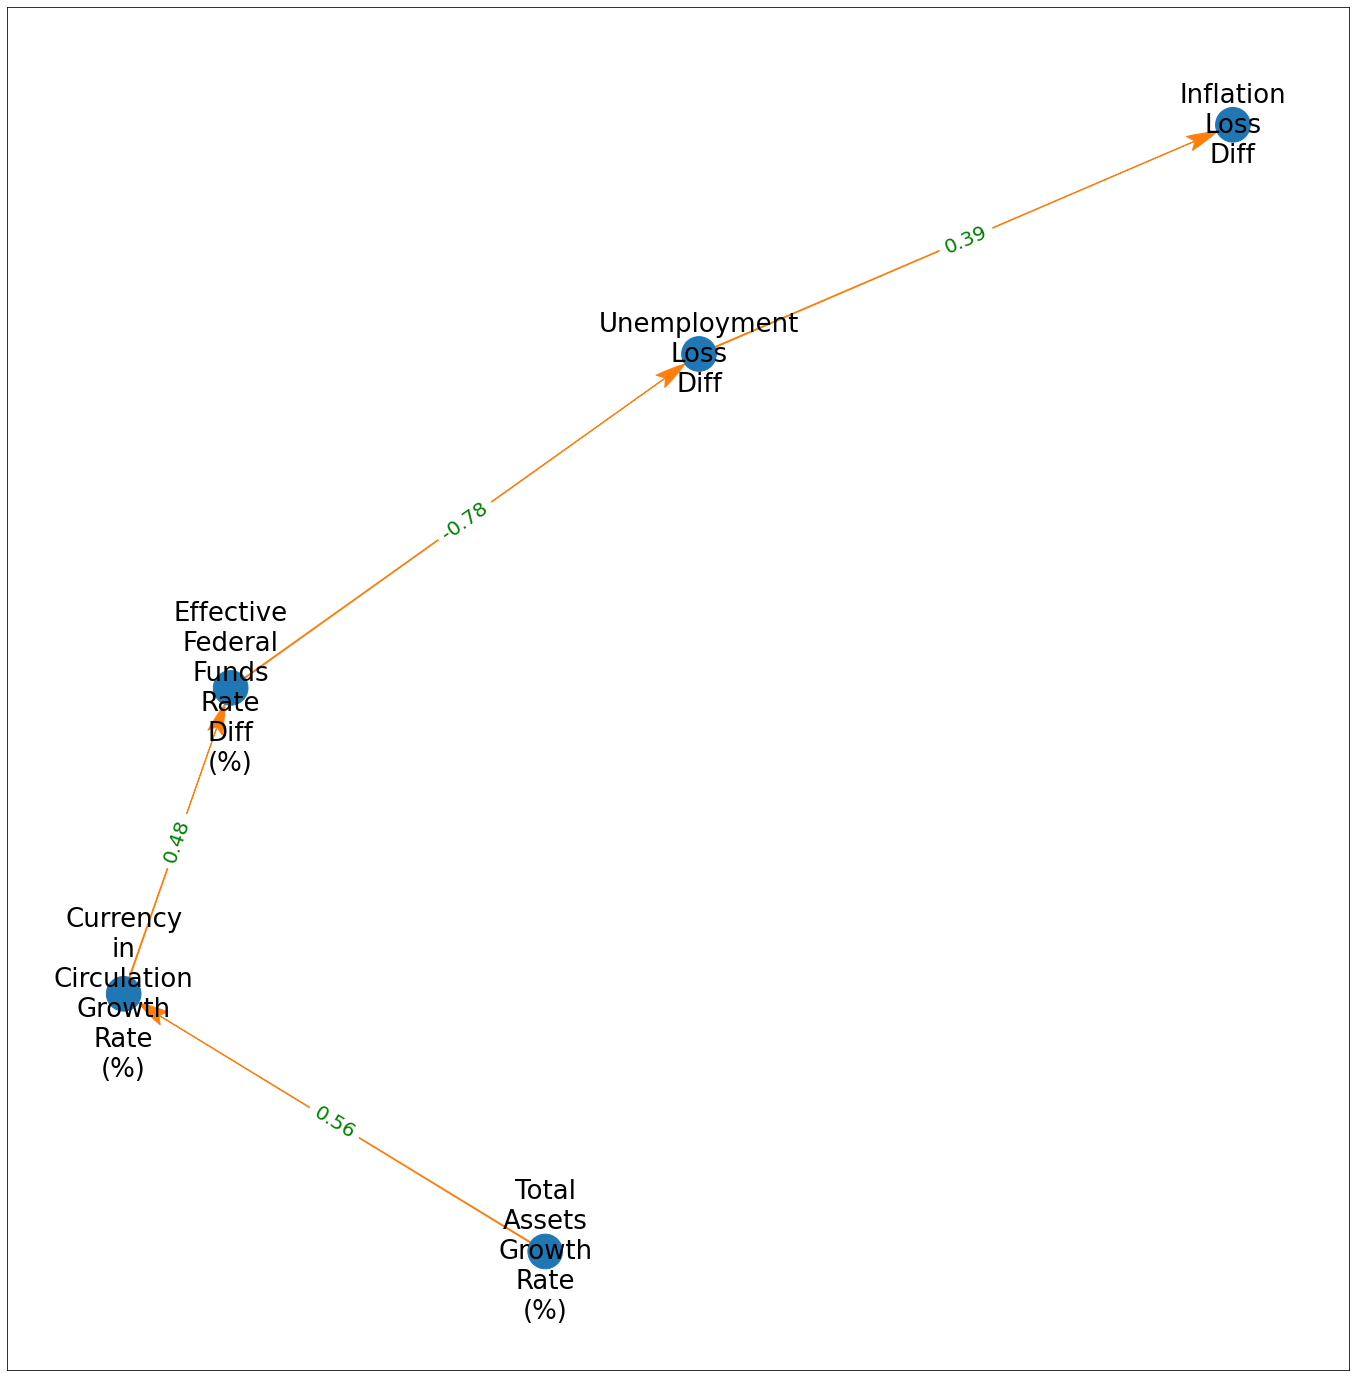

In [18]:
graph_DAG(edges, dag_df)

In [19]:
from pgmpy.estimators import PC
from pgmpy.base import DAG

keys = dag_df.keys()
c = PC(dag_df.dropna())
max_cond_vars = len(keys) - 2

variant = "parallel"
ci_test = "pearsonr"
model = c.estimate(return_type = "dag",variant= variant, 
                   significance_level = sig, 
                   max_cond_vars = max_cond_vars, ci_test = ci_test)

edges = model.edges()
pcorr = dag_df.pcorr()
weights = {}
for edge in edges:
    print(edge, ":",pcorr[edge[0]].loc[edge[1]])
skel, sep_sets = c.build_skeleton(variant = variant, ci_test = ci_test, significance_level = 0.01, 
                   max_cond_vars = max_cond_vars)
sep_sets

Working for n conditional variables: 3: 100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 24.58it/s]

('Effective\nFederal\nFunds\nRate\nDiff\n(%)', 'Unemployment\nLoss\nDiff') : -0.7810998348511248
('Currency\nin\nCirculation\nGrowth\nRate\n(%)', 'Effective\nFederal\nFunds\nRate\nDiff\n(%)') : 0.47737136278367104
('Unemployment\nLoss\nDiff', 'Inflation\nLoss\nDiff') : 0.38944242799067236
('Total\nAssets\nGrowth\nRate\n(%)', 'Currency\nin\nCirculation\nGrowth\nRate\n(%)') : 0.5563566494171939


{frozenset({'Currency\nin\nCirculation\nGrowth\nRate\n(%)',
            'Inflation\nLoss\nDiff'}): (),
 frozenset({'Inflation\nLoss\nDiff', 'Total\nAssets\nGrowth\nRate\n(%)'}): (),
 frozenset({'Currency\nin\nCirculation\nGrowth\nRate\n(%)',
            'Unemployment\nLoss\nDiff'}): ('Effective\nFederal\nFunds\nRate\nDiff\n(%)',),
 frozenset({'Total\nAssets\nGrowth\nRate\n(%)',
            'Unemployment\nLoss\nDiff'}): ('Effective\nFederal\nFunds\nRate\nDiff\n(%)',),
 frozenset({'Effective\nFederal\nFunds\nRate\nDiff\n(%)',
            'Inflation\nLoss\nDiff'}): ('Unemployment\nLoss\nDiff',),
 frozenset({'Effective\nFederal\nFunds\nRate\nDiff\n(%)',
            'Total\nAssets\nGrowth\nRate\n(%)'}): ('Unemployment\nLoss\nDiff',)}

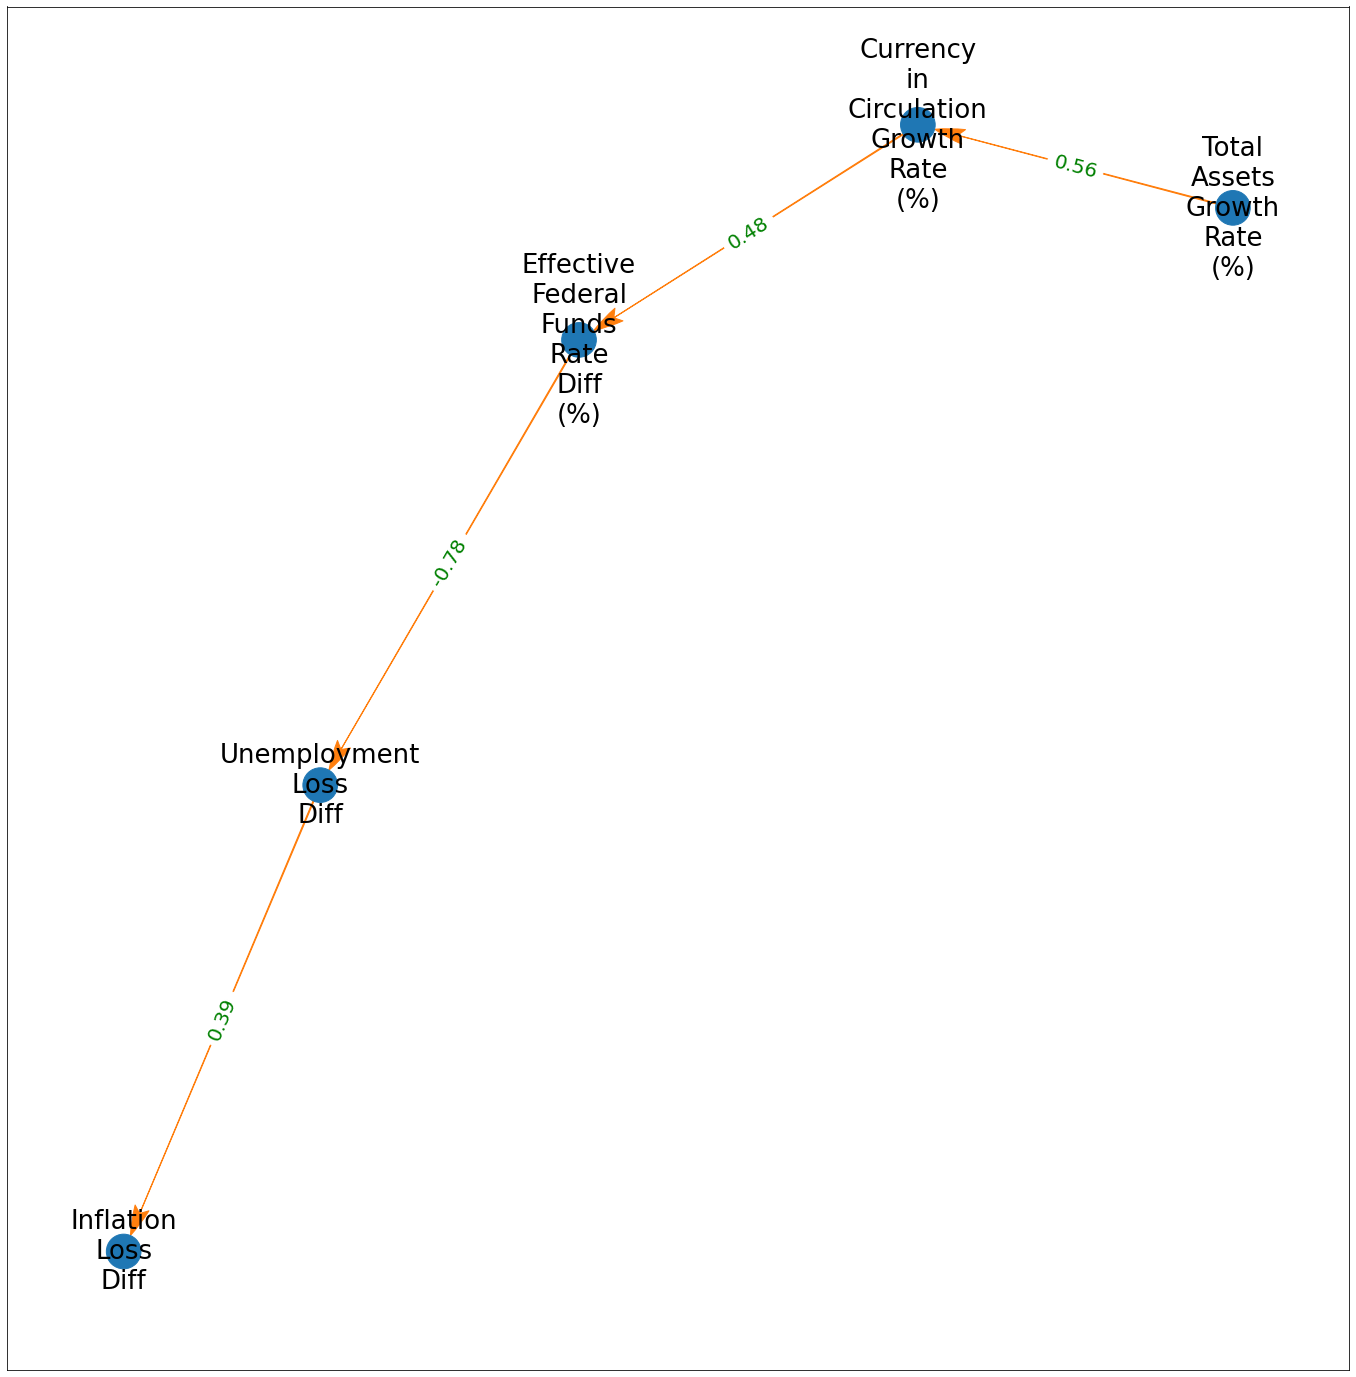

In [20]:
graph_DAG(edges, dag_df)

In [21]:
from pgmpy.estimators import PC
from pgmpy.base import DAG

keys = dag_df.keys()
c = PC(dag_df.dropna())
max_cond_vars = len(keys) - 2

variant = "parallel"
ci_test = "pearsonr"
model = c.estimate(return_type = "dag",variant= variant, 
                   significance_level = sig, 
                   max_cond_vars = max_cond_vars, ci_test = ci_test)

edges = model.edges()
pcorr = dag_df.pcorr()
weights = {}
for edge in edges:
    print(edge, ":",pcorr[edge[0]].loc[edge[1]])
skel, sep_sets = c.build_skeleton(variant = variant, ci_test = ci_test, significance_level = 0.01, 
                   max_cond_vars = max_cond_vars)
sep_sets

Working for n conditional variables: 3: 100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 23.93it/s]

('Effective\nFederal\nFunds\nRate\nDiff\n(%)', 'Unemployment\nLoss\nDiff') : -0.7810998348511248
('Currency\nin\nCirculation\nGrowth\nRate\n(%)', 'Effective\nFederal\nFunds\nRate\nDiff\n(%)') : 0.47737136278367104
('Unemployment\nLoss\nDiff', 'Inflation\nLoss\nDiff') : 0.38944242799067236
('Total\nAssets\nGrowth\nRate\n(%)', 'Currency\nin\nCirculation\nGrowth\nRate\n(%)') : 0.5563566494171939


{frozenset({'Currency\nin\nCirculation\nGrowth\nRate\n(%)',
            'Inflation\nLoss\nDiff'}): (),
 frozenset({'Inflation\nLoss\nDiff', 'Total\nAssets\nGrowth\nRate\n(%)'}): (),
 frozenset({'Currency\nin\nCirculation\nGrowth\nRate\n(%)',
            'Unemployment\nLoss\nDiff'}): ('Effective\nFederal\nFunds\nRate\nDiff\n(%)',),
 frozenset({'Total\nAssets\nGrowth\nRate\n(%)',
            'Unemployment\nLoss\nDiff'}): ('Effective\nFederal\nFunds\nRate\nDiff\n(%)',),
 frozenset({'Effective\nFederal\nFunds\nRate\nDiff\n(%)',
            'Inflation\nLoss\nDiff'}): ('Unemployment\nLoss\nDiff',),
 frozenset({'Effective\nFederal\nFunds\nRate\nDiff\n(%)',
            'Total\nAssets\nGrowth\nRate\n(%)'}): ('Unemployment\nLoss\nDiff',)}

In [22]:
for key in sep_sets:
    print(list(sep_sets[key]))

[]
[]
['Effective\nFederal\nFunds\nRate\nDiff\n(%)']
['Effective\nFederal\nFunds\nRate\nDiff\n(%)']
['Unemployment\nLoss\nDiff']
['Unemployment\nLoss\nDiff']


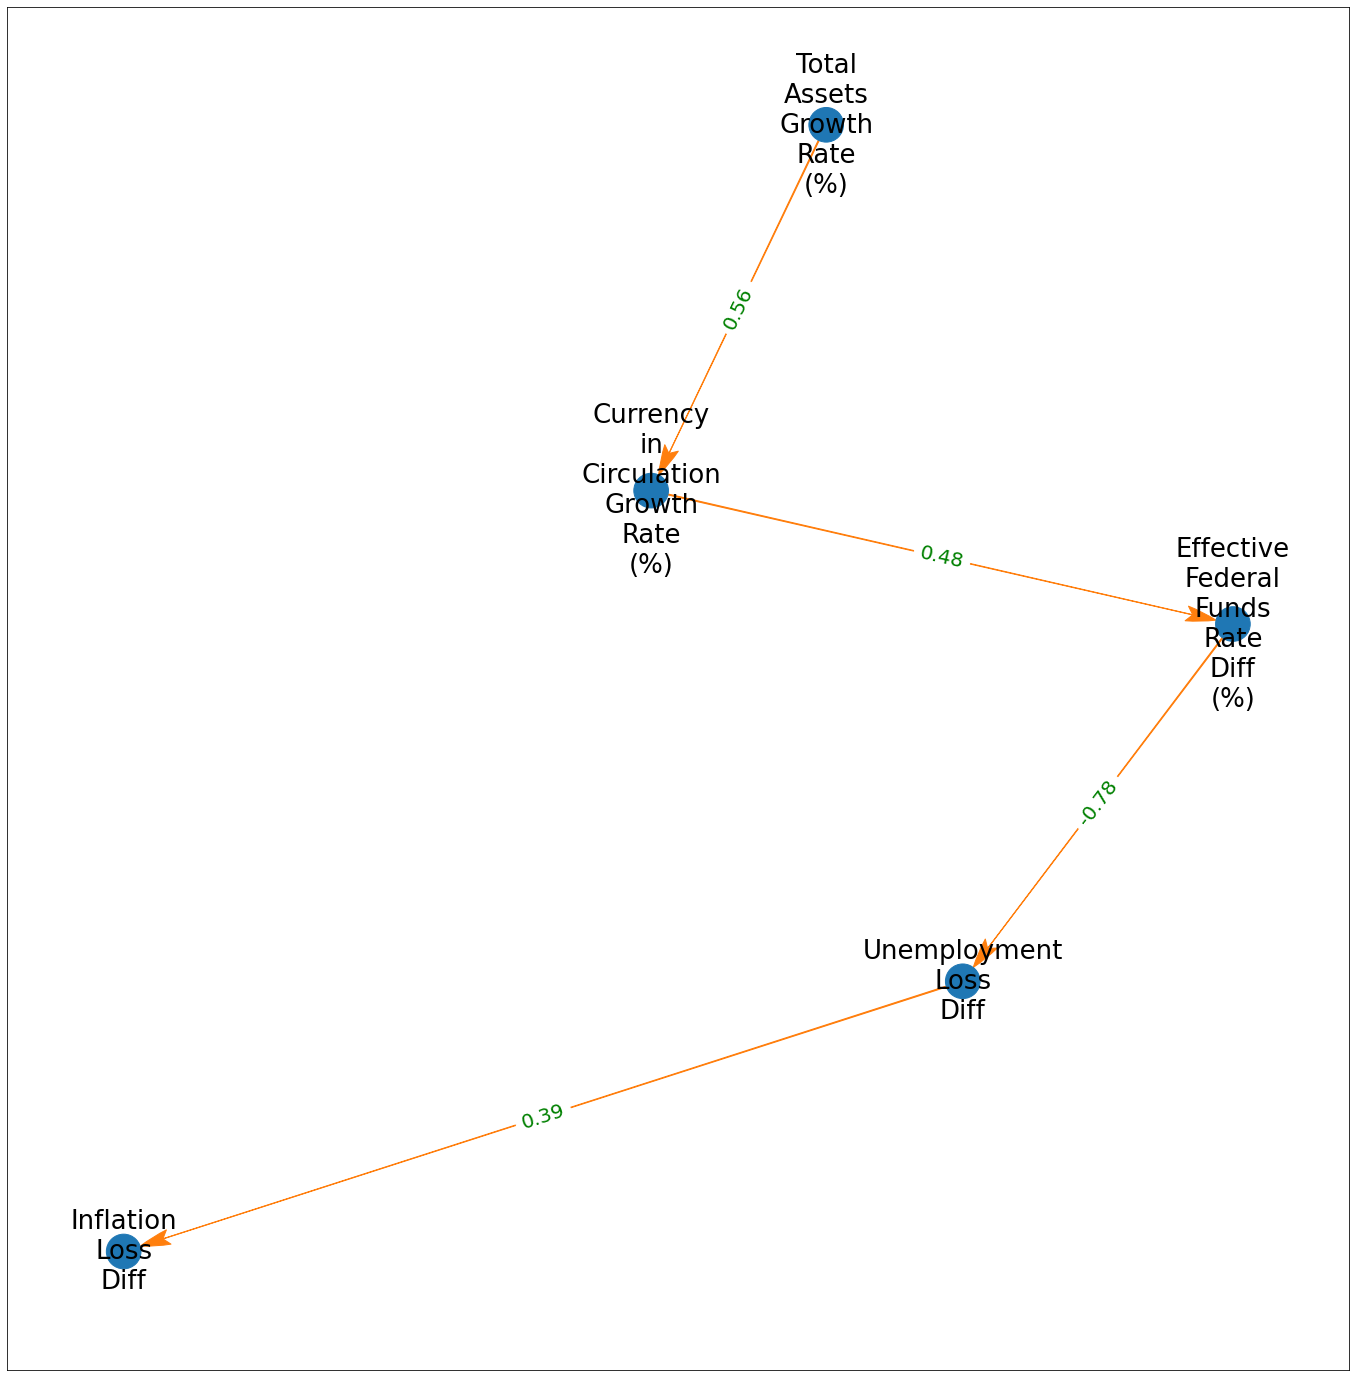

In [23]:
graph_DAG(edges, dag_df)

{frozenset({'Currency\nin\nCirculation\nGrowth\nRate\n(%)', 'Inflation\nLoss\nDiff'}): '0.35', frozenset({'Total\nAssets\nGrowth\nRate\n(%)', 'Inflation\nLoss\nDiff'}): '0.17', frozenset({'Currency\nin\nCirculation\nGrowth\nRate\n(%)', 'Unemployment\nLoss\nDiff'}): '-0.03', frozenset({'Total\nAssets\nGrowth\nRate\n(%)', 'Unemployment\nLoss\nDiff'}): '0.03', frozenset({'Effective\nFederal\nFunds\nRate\nDiff\n(%)', 'Inflation\nLoss\nDiff'}): '-0.06', frozenset({'Total\nAssets\nGrowth\nRate\n(%)', 'Effective\nFederal\nFunds\nRate\nDiff\n(%)'}): '-0.05'}


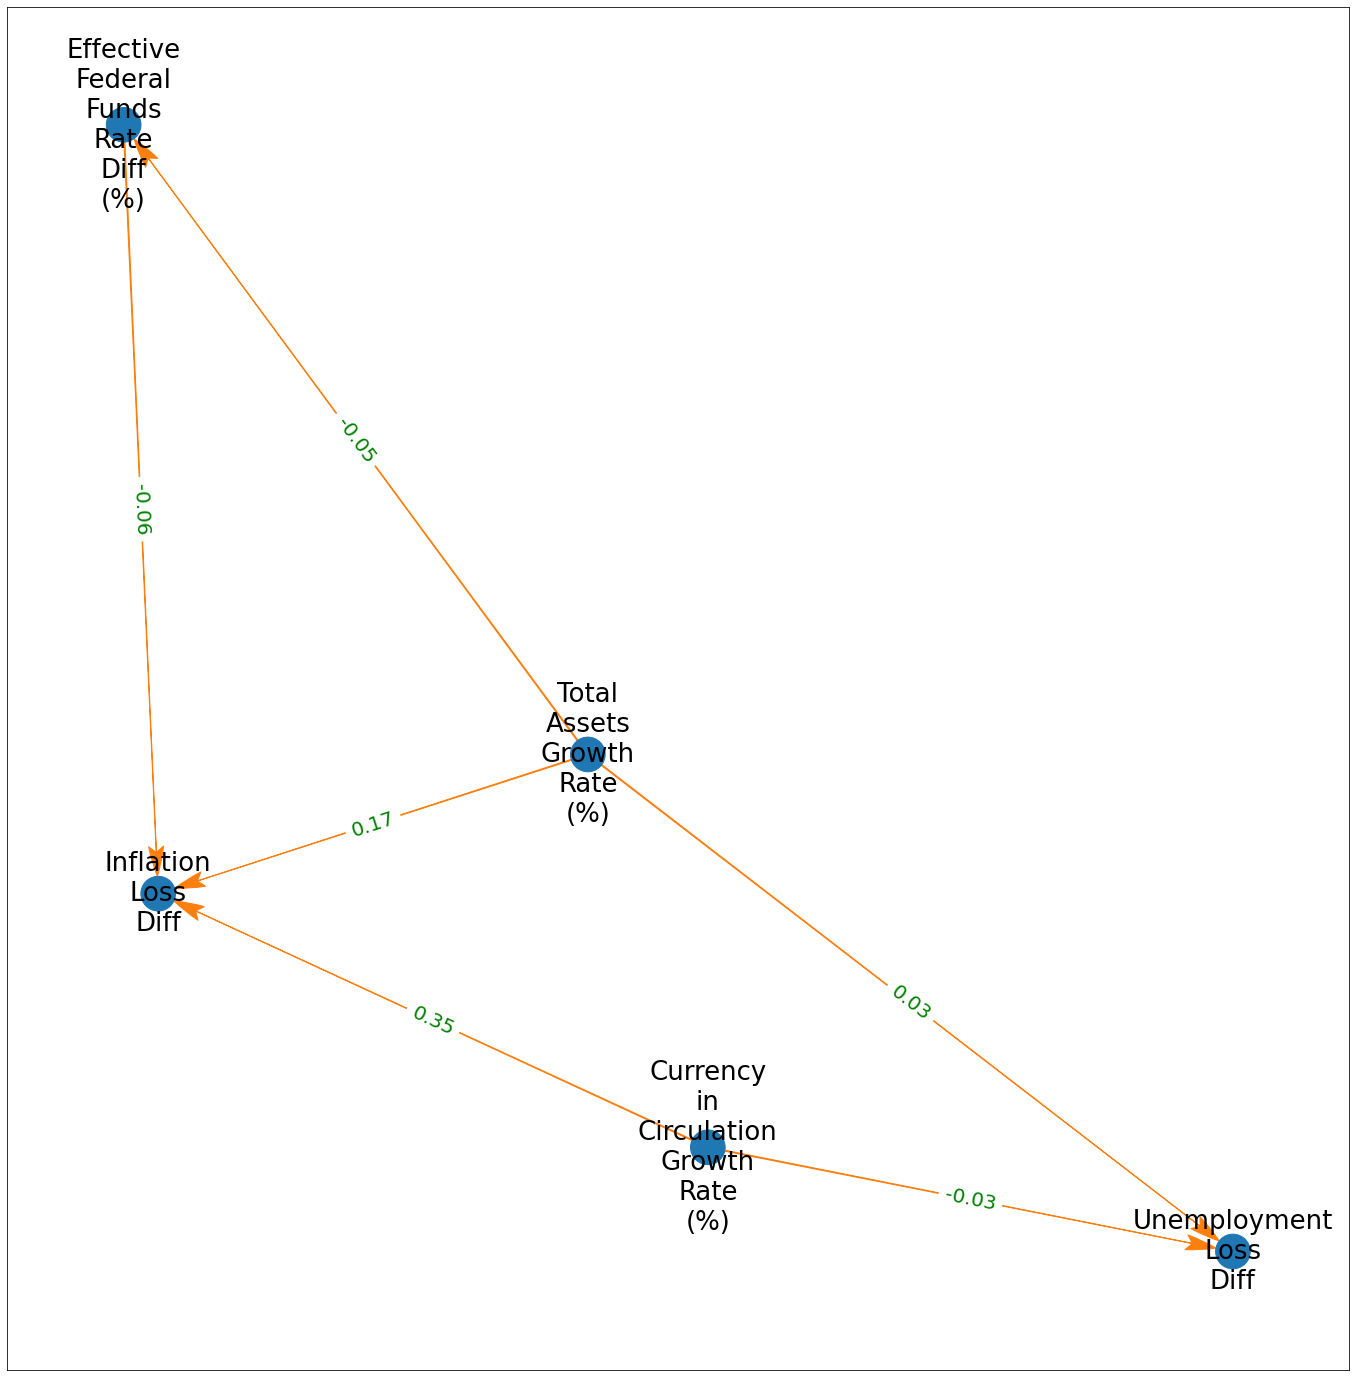

In [24]:
import matplotlib.pyplot as plt
from matplotlib.patches import ArrowStyle
import networkx as nx
plt.rcParams.update({"font.size":20})

def graph_DAG(edges, df,sep_sets, title = ""):
    graph = nx.DiGraph()
    edge_labels = {}
    pcorr = df.pcorr()
    for edge in sep_sets:
        sep_set = list(sep_sets[edge])
        key = list(edge)
#        pcorr = df[key + sep_set].pcorr()
        edge_labels[edge] = str(round(pcorr[key[0]].loc[key[1]],2))
    print(edge_labels)
    graph.add_edges_from(sep_sets.keys())
    color_map = ["C0" for g in graph]

    fig, ax = plt.subplots(figsize = (20,20))
    graph.nodes()
    plt.tight_layout()
    pos = nx.spring_layout(graph)#, k = 5/(len(sig_corr.keys())**.5))

    plt.title(title, fontsize = 30)
    nx.draw_networkx(graph, pos, node_color=color_map, node_size = 1200,
                     with_labels=True,  arrows=True,
                     #font_color = "white",
                     font_size = 26, alpha = 1,
                     width = 1, edge_color = "C1",
                     arrowstyle=ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"), ax = ax)
    nx.draw_networkx_edge_labels(graph,pos,
                                 edge_labels=edge_labels,
                                 font_color='green',
                                 font_size=20)

graph_DAG(edges, dag_df, sep_sets)

In [25]:
dag_df

,Currency\nin\nCirculation\nGrowth\nRate\n(%),Unemployment\nLoss\nDiff,Inflation\nLoss\nDiff,Effective\nFederal\nFunds\nRate\nDiff\n(%),Total\nAssets\nGrowth\nRate\n(%)
DATE,,,,,
2004-12-31,5.194730,-0.3,1.307115,1.171935,0.064704
2005-01-31,5.106115,-0.4,0.818587,1.282258,0.062053
2005-02-28,5.207152,-0.2,1.364573,1.494544,0.062248
2005-03-31,5.345141,-0.6,1.466765,1.627419,0.062119
2005-04-30,5.145490,-0.4,1.069217,1.781000,0.054415
2005-05-31,4.794532,-0.5,-0.028470,1.998065,0.055983
2005-06-30,4.619615,-0.6,-0.626641,2.010000,0.054573
2005-07-31,3.949192,-0.5,0.127585,1.999032,0.050606
2005-08-31,3.910512,-0.5,1.099509,2.070323,0.057122


<ipython-input-26-4684bbc14c4a>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(int(val * 100)) + "%" for val in ax.get_yticks()], c = "C0")
<ipython-input-26-4684bbc14c4a>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels([str(int(val)) + "%" for val in ax2.get_yticks()], c = "C1")
<ipython-input-26-4684bbc14c4a>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_yticklabels(ax3.get_yticks(), alpha = .2, c = "k")


Text(2022-01-01 00:00:00, 0.955, '0 ')

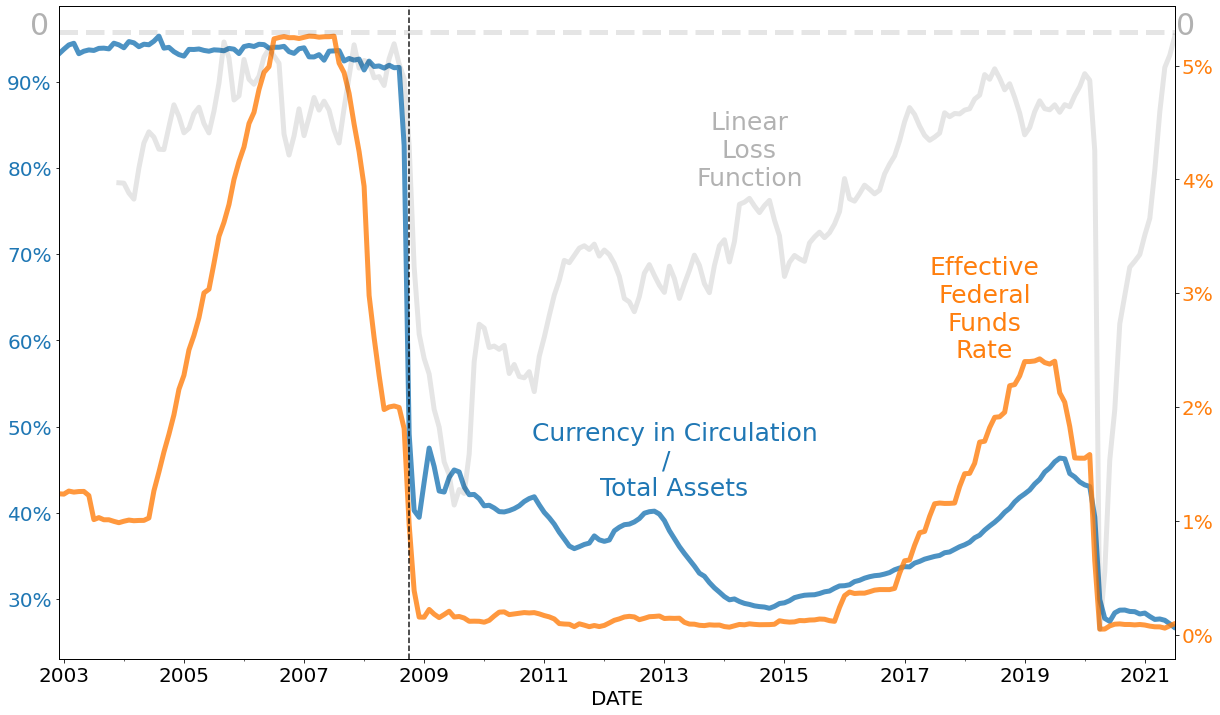

In [26]:
figsize = (20,12)
fig,ax = plt.subplots(figsize = figsize)

ax2 = ax.twinx()
ax3 = ax.twinx()
data[["Currency in Circulation / Total Assets"]].plot(legend = False, 
                                                      linewidth = 5, 
                                                      alpha = .8,
                                                      ax = ax)
data[["Effective Federal Funds Rate (%)"]].plot(legend = False, 
                                                      linewidth = 5, 
                                                      alpha = .8,
                                                      ax = ax2,
                                                        c = "C1")
data[["Linear Loss"]].iloc[:-1].plot(legend = False, 
                                                      linewidth = 5, 
                                                      alpha = .1,
                                                      ax = ax3,
                                                        c = "k")

ax.set_yticklabels([str(int(val * 100)) + "%" for val in ax.get_yticks()], c = "C0")
ax2.set_yticklabels([str(int(val)) + "%" for val in ax2.get_yticks()], c = "C1")
ax3.set_yticklabels(ax3.get_yticks(), alpha = .2, c = "k")
ax3.set_yticks([])

ax3.axhline(0, c = "k", alpha = .1, linewidth = 5, ls = "--")

plt.axvline(datetime.datetime(2008,10,1), c = "k", ls = "--", alpha = .9)
ax.text(datetime.datetime(2013,3,1), .42, "Currency in Circulation\n/  \nTotal Assets", fontsize = 25, c = "C0", 
        ha = "center")
ax.text(datetime.datetime(2018,5,1), .58, "Effective\nFederal\nFunds\nRate", fontsize = 25, c = "C1", 
        ha = "center")
ax.text(datetime.datetime(2014,6,1), .78, "Linear\nLoss\nFunction", fontsize = 25, c = "k", alpha = .3, 
        ha = "center")
ax.text(datetime.datetime(2002,10,1), .955, "0", fontsize = 30, c = "k", alpha = .3, 
        ha = "right")
ax.text(datetime.datetime(2022,1,1), .955, "0 ", fontsize = 30, c = "k", alpha = .3, 
        ha = "right")

(array([-100.,  -80.,  -60.,  -40.,  -20.,    0.,   20.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

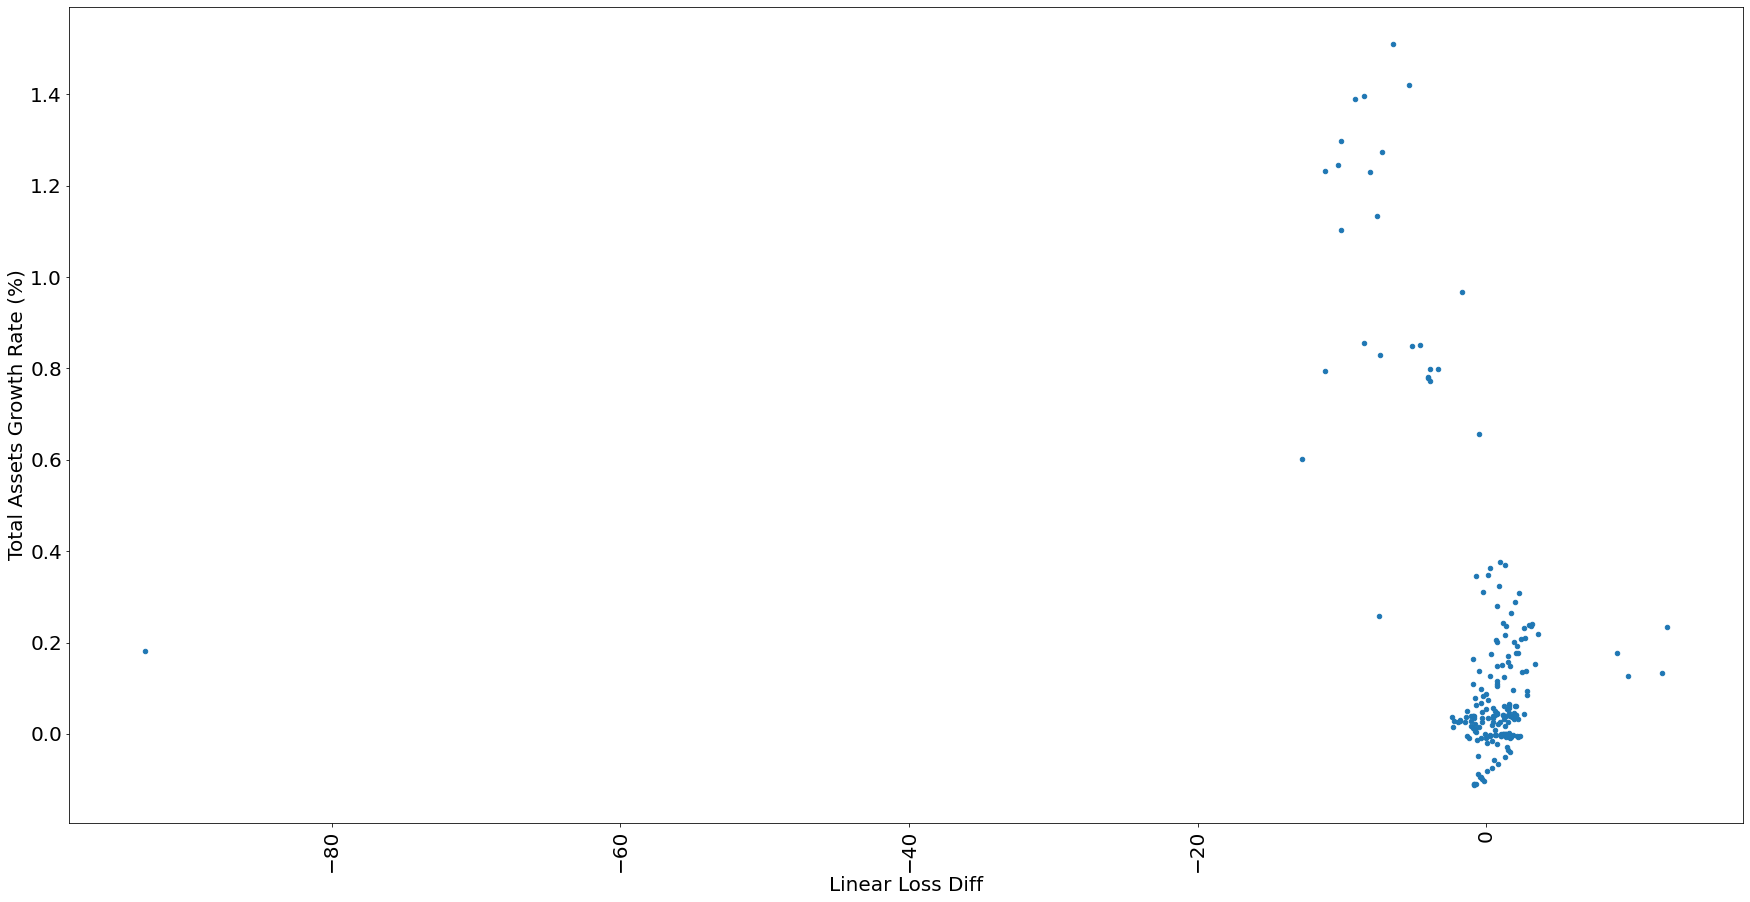

In [27]:
fig, ax = plt.subplots(figsize = (30,15))
data[["Linear Loss Diff", "Total Assets Growth Rate (%)"]].plot.scatter(x = "Linear Loss Diff", y = "Total Assets Growth Rate (%)", ax = ax)
plt.xticks(rotation=90)


(array([-16., -14., -12., -10.,  -8.,  -6.,  -4.,  -2.,   0.,   2.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

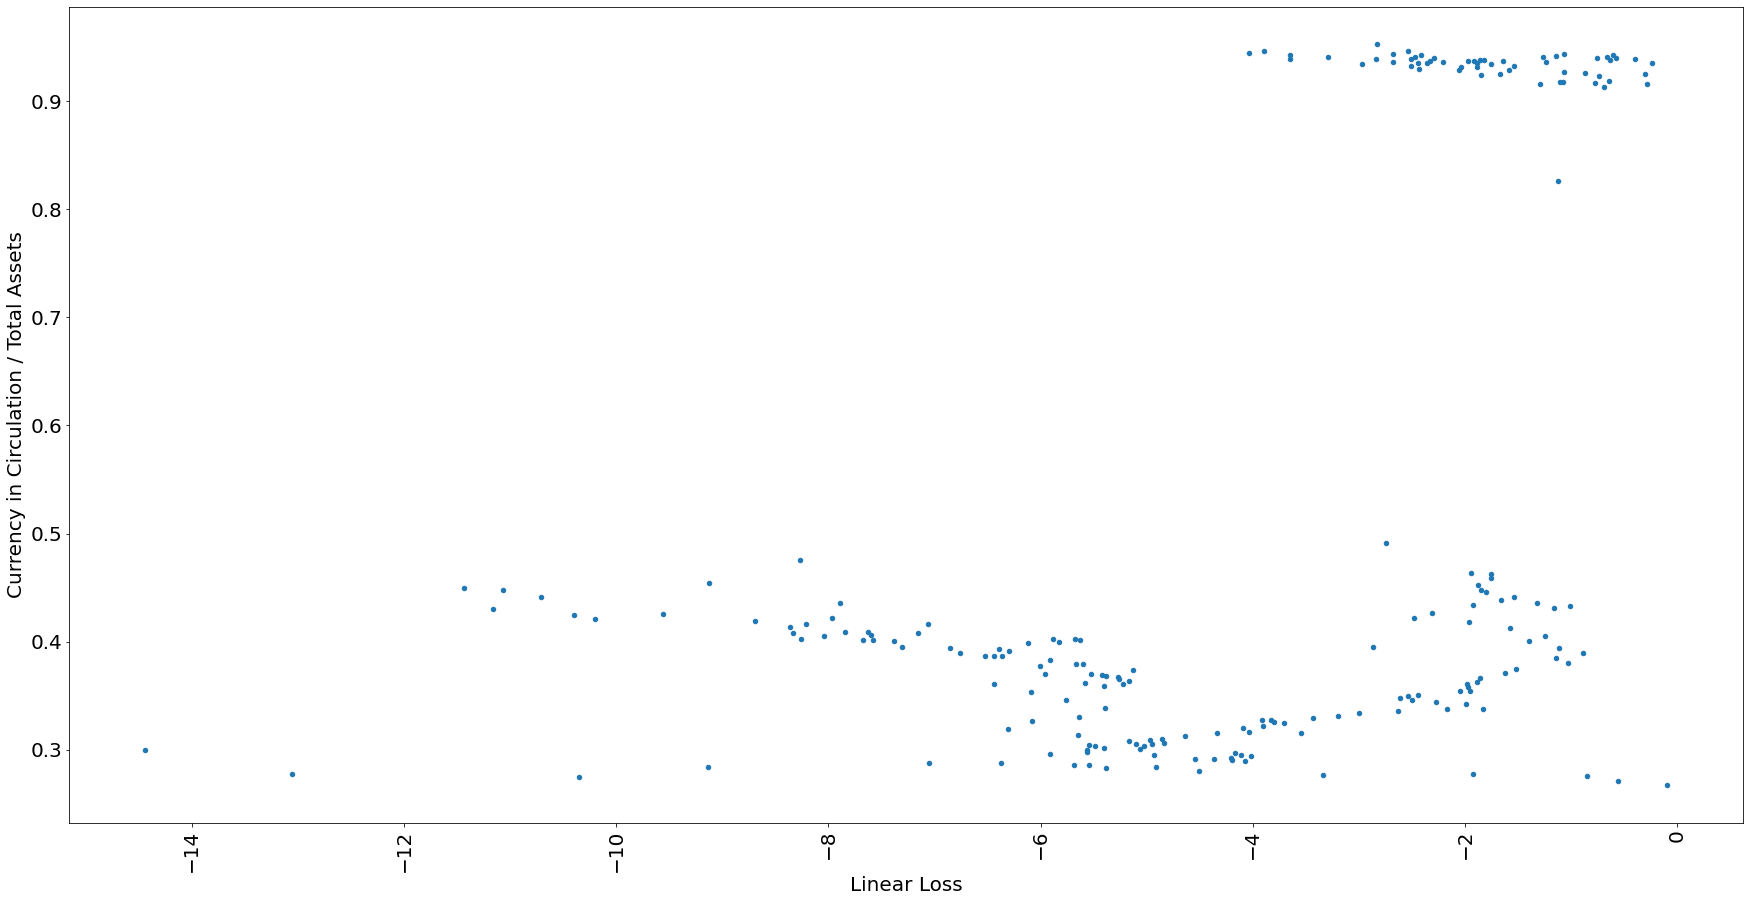

In [28]:
fig, ax = plt.subplots(figsize = (30,15))
data.iloc[:-1].plot.scatter(x = "Linear Loss", y = "Currency in Circulation / Total Assets", ax = ax)
plt.xticks(rotation=90)
